---
# **Property Assessment CCAO:** FIN 550 Final Project

This R script contains the full workflow to:
   - Load and process (ETL) Cook County property datasets
   - Perform Exploratory Data Analysis (EDA)
   - Develop and apply models for predicting residential property values
 
The script produces the final 'assessed_value.csv' file for project submission.


---
### **Extract, Transform, Load**

##### Install & Load Required Packages

In [138]:
# Install and load required packages

# Function to install packages if not already installed
install_if_missing <- function(package) {
  if (!require(package, character.only = TRUE, quietly = TRUE)) {
    install.packages(package, dependencies = TRUE)
  }
}

# Data manipulation and ETL
install_if_missing("readr")
install_if_missing("dplyr")
install_if_missing("tidyr")
install_if_missing("data.table")

# EDA and visualization
install_if_missing("ggplot2")
install_if_missing("corrplot")
install_if_missing("GGally")
install_if_missing("skimr")

# Modeling - Linear Models
install_if_missing("caret")
install_if_missing("glmnet")

# Modeling - Tree-based methods
install_if_missing("rpart")
install_if_missing("rpart.plot")
install_if_missing("randomForest")
install_if_missing("xgboost")

# Model evaluation and tuning
install_if_missing("Metrics")
install_if_missing("MLmetrics")

# Missing data imputation
install_if_missing("mice")

# Load libraries
library(readr)       # Reading CSV files
library(dplyr)       # Data manipulation
library(tidyr)       # Data tidying
library(data.table)  # Fast data manipulation

library(ggplot2)     # Visualization
library(corrplot)    # Correlation plots
library(GGally)      # Pairwise plots
library(skimr)       # Summary statistics

library(caret)       # Model training and evaluation
library(glmnet)      # Regularized regression (Ridge, Lasso, Elastic Net)

library(rpart)       # Decision trees
library(rpart.plot)  # Decision tree visualization
library(randomForest) # Random Forest
library(xgboost)     # XGBoost

library(Metrics)     # Model evaluation metrics
library(MLmetrics)   # Additional ML metrics

library(mice)        # Multiple imputation by chained equations

# Set random seed for reproducibility
set.seed(550)

cat("All required packages loaded successfully.\n")


All required packages loaded successfully.


##### Load the Datasets

In [139]:
# Load the datasets
historic_data <- read_csv('data/historic_property_data.csv')
predict_set <- read_csv('data/predict_property_data.csv')

# Display basic information about the datasets
cat("Historic Data Shape:", dim(historic_data), "\n")
cat("Predict Set Shape:", dim(predict_set), "\n")


Rows: 50000 Columns: 63
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): meta_cdu, meta_deed_type, geo_property_city, geo_property_zip, geo...
dbl (52): sale_price, meta_class, meta_town_code, meta_nbhd, meta_certified_...
lgl  (3): ind_large_home, ind_garage, ind_arms_length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10000 Columns: 63
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): meta_cdu, meta_deed_type, geo_property_city, geo_property_zip, geo...
dbl (52): pid, meta_class, meta_town_code, meta_nbhd, meta_certified_est_bld...
lgl  (3): ind_large_home, ind_garage, ind_arms_length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Historic Data Shape: 50000 63 
Predict Set Shape: 10000 63 


##### Data Types *(Nominal, Ordinal, Integer, Continuous, Booleen)*

##### Ordinal Reclass Candidates (Codebook Guided)

The following categorical fields have an inherent order and will be coerced to ordered factors:
- `char_apts`: Two, Three, Four, Five, Six, None
- `char_attic_fnsh`: Living Area, Partial, None
- `char_attic_type`: Full, Partial, None
- `char_bsmt`: Full, Slab, Partial, Crawl
- `char_bsmt_fin`: Formal Rec Room, Apartment, Unfinished
- `char_cnst_qlty`: Deluxe, Average, Poor
- `char_gar1_size`: 1 car, 1.5 cars, 2 cars, 2.5 cars, 3 cars, 3.5 cars, 4 cars, 0 cars
- `char_repair_cnd`: Above Average, Average, Below Average
- `char_site`: Beneficial To Value, Not Relevant, Detracts From Value
- `char_type_resd`: 1 Story, 1.5 Story, 1.6 Story, 1.7 Story, 1.8 Story, 1.9 Story, 2 Story, 3 Story +, Split Level

In [140]:
# Identify and reclassify ordered categorical variables to ordered factors
cat("
=== Ordinal Reclassification (Codebook Guided) ===
")

ordinal_maps <- list(
  char_apts       = c("Two", "Three", "Four", "Five", "Six", "None"),
  char_attic_fnsh = c("Living Area", "Partial", "None"),
  char_attic_type = c("Full", "Partial", "None"),
  char_bsmt       = c("Full", "Slab", "Partial", "Crawl"),
  char_bsmt_fin   = c("Formal Rec Room", "Apartment", "Unfinished"),
  char_cnst_qlty  = c("Deluxe", "Average", "Poor"),
  char_gar1_size  = c("1 car", "1.5 cars", "2 cars", "2.5 cars", "3 cars", "3.5 cars", "4 cars", "0 cars"),
  char_repair_cnd = c("Above Average", "Average", "Below Average"),
  char_site       = c("Beneficial To Value", "Not Relevant To Value", "Detracts From Value"),
  char_type_resd  = c("1 Story", "1.5 Story", "1.6 Story", "1.7 Story", "1.8 Story", "1.9 Story", "2 Story", "3 Story +", "Split Level")
)

ordinal_vars <- names(ordinal_maps)

# helper to tidy and relevel
recode_to_ordered <- function(df, var, levels_vec) {
  if(!var %in% names(df)) return(df)
  # summarise current state
  cat(sprintf("
- %s
", var))
  print(table(df[[var]], useNA = "ifany"))

  # Keep existing categories to avoid coercing values to NA when not in the planned order
  current_vals <- df[[var]]
  current_levels <- sort(unique(as.character(current_vals[!is.na(current_vals)])))
  extra_levels <- setdiff(current_levels, levels_vec)
  if(length(extra_levels) > 0) {
    cat(sprintf("  [Ordinal] Adding %d unexpected levels for %s: %s
", length(extra_levels), var, paste(extra_levels, collapse = ", ")))
  }
  ordered_levels <- c(levels_vec, setdiff(extra_levels, levels_vec))

  df[[var]] <- factor(as.character(current_vals), levels = ordered_levels, ordered = TRUE)
  df
}

for(var in names(ordinal_maps)) {
  historic_data <- recode_to_ordered(historic_data, var, ordinal_maps[[var]])
  predict_set   <- recode_to_ordered(predict_set,   var, ordinal_maps[[var]])
  if(exists("codebook_df")) {
    idx <- which(codebook_df$var_name_standard == var)
    if(length(idx)) {
      codebook_df$var_type[idx] <- "Ordinal"
      codebook_df$var_data_type[idx] <- "categorical"
    }
  }
}

cat("
Ordinal coercion complete.
")


=== Ordinal Reclassification (Codebook Guided) ===

- char_apts

    1     2     3     4     5     6  <NA> 
   18  4150  1572   557   122   488 43093 
  [Ordinal] Adding 6 unexpected levels for char_apts: 1, 2, 3, 4, 5, 6

- char_apts

   1    2    3    4    5    6 <NA> 
   3  731  279  117   14   78 8778 
  [Ordinal] Adding 6 unexpected levels for char_apts: 1, 2, 3, 4, 5, 6

- char_attic_fnsh

    1     2     3  <NA> 
 6315   338  9894 33453 
  [Ordinal] Adding 3 unexpected levels for char_attic_fnsh: 1, 2, 3

- char_attic_fnsh

   1    2    3 <NA> 
1274   58 1906 6762 
  [Ordinal] Adding 3 unexpected levels for char_attic_fnsh: 1, 2, 3

- char_attic_type

    1     2     3  <NA> 
 9452  6698 33824    26 
  [Ordinal] Adding 3 unexpected levels for char_attic_type: 1, 2, 3

- char_attic_type

   1    2    3 <NA> 
1834 1361 6802    3 
  [Ordinal] Adding 3 unexpected levels for char_attic_type: 1, 2, 3

- char_bsmt

    1     2     3     4  <NA> 
30035  6762 10408  2770    25 
  [Ordin

In [141]:
# Load codebook and helper functions for variable typing
if(!exists("codebook_df")) {
  codebook_df <- read.csv("data/codebook.csv", stringsAsFactors = FALSE)
}

# Create a lookup table: name -> type (using codebook var_type and var_data_type for more granularity)
get_codebook_types <- function() {
  out <- codebook_df
  out <- out[!is.na(out$var_name_standard) & nzchar(out$var_name_standard), ]
  
  if("var_description" %in% names(out)) {
    var_description_map <- setNames(out$var_description, out$var_name_standard)
  } else {
    var_description_map <- setNames(rep(NA_character_, nrow(out)), out$var_name_standard)
  }
  
  var_type_map <- setNames(out$var_type, out$var_name_standard)
  var_data_type_map <- setNames(out$var_data_type, out$var_name_standard)
  
  list(type = var_type_map, datatype = var_data_type_map, description = var_description_map)
}

# Map a column to a user-friendly type bucket using the codebook
codebook_col_type <- function(var, cb_types, df = NULL) {
  # Allow manual reclassifications to override the codebook
  if (exists("variable_classifications")) {
    override <- variable_classifications$Classification[variable_classifications$Variable == var]
    if (length(override) > 0) {
      if (override %in% c("Integer", "Continuous")) return(override)
      if (override %in% c("Nominal", "Ordinal", "Boolean", "Character")) return(override)
    }
  }
  if (exists("ordinal_vars") && var %in% ordinal_vars) {
    return("Ordinal")
  }
  if (exists("integer_vars") && var %in% integer_vars) {
    return("Integer")
  }
  if (exists("continuous_vars") && var %in% continuous_vars) {
    return("Continuous")
  }

  # Heuristic for ordinal naming (useful when codebook is silent)
  name_suggests_ordinal <- grepl("qlty|quality|cnd|condition|size|rating|grade", var, ignore.case = TRUE)

  in_cb <- var %in% names(cb_types$type)
  type1 <- if(in_cb) cb_types$type[[var]] else NA
  type2 <- if(in_cb) cb_types$datatype[[var]] else NA
  desc  <- if(in_cb) cb_types$description[[var]] else NA
  desc_lower <- if(!is.na(desc)) tolower(desc) else ""
  type2_lower <- if(!is.na(type2)) tolower(type2) else ""
  type1_lower <- if(!is.na(type1)) tolower(type1) else ""

  # Honor explicit ordinal labels in the codebook
  if(type1_lower == "ordinal" || type2_lower == "ordinal") return("Ordinal")
  
  # Logical/indicator
  if(type2_lower == "logical" || type1_lower == "ind") return("Boolean")
  
  # Ordinal hints in description
  if(nzchar(desc_lower) && grepl("ordinal|order|rank|level|grade|quality", desc_lower)) {
    return("Ordinal")
  }

  # If the name implies ordering, honor that even when metadata is unclear
  if(name_suggests_ordinal) {
    return("Ordinal")
  }
  
  # Categorical types
  if(type2_lower == "categorical") {
    if(nzchar(desc_lower) && grepl("ordinal|order|rank|level|grade|quality", desc_lower)) {
      return("Ordinal")
    }
    if(type1_lower == "ordinal") return("Ordinal")
    return("Nominal")
  }
  
  # Character storage
  if(type2_lower == "character") return("Character")
  
  # Numeric detection: use codebook hint or data profile to split integer vs continuous
  if(type2_lower %in% c("numeric", "integer", "double")) {
    if(!is.null(df) && var %in% names(df) && is.numeric(df[[var]])) {
      non_na <- df[[var]][!is.na(df[[var]])]
      if(length(non_na) == 0) return("Continuous")
      whole_pct <- mean(abs(non_na - round(non_na)) < .Machine$double.eps^0.5)
      if(whole_pct > 0.98) return("Integer")
    }
    return("Continuous")
  }
  
  # Meta/char/geo/econ fall back to Nominal if not otherwise typed
  if(type1_lower %in% c("char", "meta", "geo", "econ")) return("Nominal")
  
  # If not in codebook, attempt to infer from data frame
  if(!is.null(df) && var %in% names(df)) {
    if(is.ordered(df[[var]])) return("Ordinal")
    if(is.factor(df[[var]])) return("Nominal")
    if(is.numeric(df[[var]])) {
      non_na <- df[[var]][!is.na(df[[var]])]
      if(length(non_na) && mean(abs(non_na - round(non_na)) < .Machine$double.eps^0.5) > 0.98) return("Integer")
      return("Continuous")
    }
    if(is.logical(df[[var]])) return("Boolean")
    if(is.character(df[[var]])) return("Character")
  }
  
  # Default fallback
  return(ifelse(name_suggests_ordinal, "Ordinal", "Unknown"))
}

# Print counts and feature names by type for both datasets (ETL stage)
cb_types <- get_codebook_types()
print_type_summary <- function(df, dataset_name, cb_types) {
  type_order <- c("Numeric", "Nominal", "Ordinal", "Character", "Boolean", "Unknown")
  classified <- data.frame(
    Variable = names(df),
    Type = sapply(names(df), function(v) codebook_col_type(v, cb_types, df)),
    stringsAsFactors = FALSE
  )
  cat("
", dataset_name, ":
", sep = "")
  for(t in type_order) {
    vars_of_type <- classified %>% filter(Type == t) %>% pull(Variable)
    cat(sprintf("  %-9s: %3d vars
", t, length(vars_of_type)))
    if(length(vars_of_type) > 0) {
      cat("    ", paste(vars_of_type, collapse = ", "), "
", sep = "")
    }
  }
}

cat("
=== Codebook-Based Data Types (pre-imputation) ===
")
print_type_summary(historic_data, "Historic Data", cb_types)
print_type_summary(predict_set,  "Predict Set", cb_types)




=== Codebook-Based Data Types (pre-imputation) ===

Historic Data:
  Numeric  :   0 vars
  Nominal  :   0 vars
  Ordinal  :  10 vars
    char_apts, char_bsmt, char_bsmt_fin, char_attic_type, char_cnst_qlty, char_site, char_gar1_size, char_repair_cnd, char_type_resd, char_attic_fnsh
  Character:   8 vars
    meta_cdu, meta_deed_type, geo_property_city, geo_property_zip, geo_fips, geo_municipality, geo_school_elem_district, geo_school_hs_district
  Boolean  :   3 vars
    ind_large_home, ind_garage, ind_arms_length
  Unknown  :   0 vars

Predict Set:
  Numeric  :   0 vars
  Nominal  :   0 vars
  Ordinal  :  10 vars
    char_apts, char_bsmt, char_bsmt_fin, char_attic_type, char_cnst_qlty, char_site, char_gar1_size, char_repair_cnd, char_type_resd, char_attic_fnsh
  Character:   8 vars
    meta_cdu, meta_deed_type, geo_property_city, geo_property_zip, geo_fips, geo_municipality, geo_school_elem_district, geo_school_hs_district
  Boolean  :   3 vars
    ind_large_home, ind_garage, ind_arms

## Numeric Reclassification (Integer vs Continuous)
Use codebook hints and value profiles to split numeric variables into integer-like counts vs continuous measures before imputation.


In [142]:
# Reclassify numeric variables into Integer vs Continuous (codebook-informed, manual lists)
cat("
=== Numeric Reclassification (Integer vs Continuous) ===
")

# Manual lists derived from codebook.md
integer_vars <- c("char_age", "char_beds", "char_fbath", "char_frpl", "char_hbath", "char_ncu", "char_rooms", "econ_foreclosures_month_town", "econ_foreclosures_quarter_town", "geo_tract_pop", "geo_fs_flood_risk_direction", "geo_fs_flood_factor", "meta_year", "meta_num_288s_active", "meta_num_288s_ended", "time_sale_year", "time_sale_quarter", "time_sale_month", "time_sale_week", "time_sale_day", "time_sale_week_of_year", "time_sale_day_of_year")
continuous_vars <- c("char_bldg_sf", "char_hd_sf", "char_ot_impr", "char_volume", "econ_midincome", "econ_tax_amt_paid", "econ_tax_rate", "geo_black_perc", "geo_asian_perc", "geo_his_perc", "geo_white_perc", "geo_other_perc", "geo_longitude", "geo_latitude", "meta_per_ass", "meta_2yr_pri_board_est_bldg", "meta_2yr_pri_board_est_land", "meta_1yr_pri_board_est_bldg", "meta_1yr_pri_board_est_land", "meta_mailed_est_bldg", "meta_mailed_est_land", "meta_certified_est_bldg", "meta_certified_est_land", "meta_sale_price", "meta_nbhd_avg", "meta_nbhd_med")
numeric_vars_all <- c(integer_vars, continuous_vars)

cat(sprintf("Identified %d integer vars, %d continuous vars
", length(integer_vars), length(continuous_vars)))



=== Numeric Reclassification (Integer vs Continuous) ===
Identified 22 integer vars, 26 continuous vars


##### Observe Missing Values

In [143]:
# Analyze missing values by codebook-based data type
cat("
=== Missing Values by Data Type (Codebook-Informed) ===
")

cb_types <- get_codebook_types()

# Calculate missing by codebook-based type
analyze_missing_by_codebook_type <- function(data, dataset_name, cb_types) {
  cat("
", dataset_name, ":
", sep = "")
  cols_with_missing <- names(data)[colSums(is.na(data)) > 0]
  if(length(cols_with_missing) == 0) {
    cat("  No missing values found.
")
    return(NULL)
  }
  cb_type_per_col <- sapply(cols_with_missing, function(v) codebook_col_type(v, cb_types, data))
  types_for_summary <- c("Integer", "Continuous", "Nominal", "Ordinal", "Character", "Boolean", "Unknown")
  total_missing <- sum(is.na(data))
  missing_vals_by_type <- sapply(types_for_summary, function(btype) {
    these_cols <- cols_with_missing[cb_type_per_col == btype]
    if(length(these_cols)>0) sum(is.na(data[these_cols])) else 0
  })
  missing_pct_by_type <- if(total_missing>0) missing_vals_by_type/total_missing*100 else rep(0, length(missing_vals_by_type))
  names(missing_vals_by_type) <- types_for_summary
  names(missing_pct_by_type) <- types_for_summary
  for(type_str in types_for_summary) {
    cat(sprintf("  %-11s: %.2f%% (%d missing values)
", 
                type_str,
                round(missing_pct_by_type[type_str], 2),
                missing_vals_by_type[type_str]))
  }
  cat(sprintf("  Total:       100.00%% (%d missing values)
", total_missing))
}

analyze_missing_by_codebook_type(historic_data, "Historic Data", cb_types)
analyze_missing_by_codebook_type(predict_set, "Predict Set", cb_types)




=== Missing Values by Data Type (Codebook-Informed) ===

Historic Data:
  Integer    : 0.18% (511 missing values)
  Continuous : 0.34% (972 missing values)
  Nominal    : 54.37% (153596 missing values)
  Ordinal    : 27.18% (76778 missing values)
  Character  : 17.69% (49964 missing values)
  Boolean    : 0.24% (672 missing values)
  Unknown    : 0.00% (0 missing values)
  Total:       100.00% (282493 missing values)

Predict Set:
  Integer    : 0.01% (3 missing values)
  Continuous : 0.00% (0 missing values)
  Nominal    : 54.21% (30134 missing values)
  Ordinal    : 28.01% (15571 missing values)
  Character  : 17.76% (9874 missing values)
  Boolean    : 0.01% (3 missing values)
  Unknown    : 0.00% (0 missing values)
  Total:       100.00% (55585 missing values)


In [144]:
# Print all columns and their missing % for both datasets, ordered by Percent_Missing DESC

get_missing_pct_df <- function(df, dataset_name) {
  pct_missing <- colMeans(is.na(df)) * 100
  data.frame(
    Dataset = dataset_name,
    Column = names(df),
    Percent_Missing = round(pct_missing, 2),
    row.names = NULL
  )
}

missing_historic <- get_missing_pct_df(historic_data, "historic_data")
missing_predict <- get_missing_pct_df(predict_set, "predict_set")

missing_all <- rbind(missing_historic, missing_predict)

# Order by Percent_Missing DESC
missing_all <- missing_all[order(-missing_all$Percent_Missing), ]

cat("\nAll columns and their percent missing (both datasets):\n")
print(missing_all)



All columns and their percent missing (both datasets):
          Dataset                      Column Percent_Missing
102   predict_set             char_renovation           99.51
39  historic_data             char_renovation           99.48
7   historic_data                    meta_cdu           94.34
70    predict_set                    meta_cdu           94.18
74    predict_set                   char_apts           87.78
11  historic_data                   char_apts           86.19
103   predict_set                  char_porch           82.45
40  historic_data                  char_porch           81.45
101   predict_set             char_attic_fnsh           67.62
38  historic_data             char_attic_fnsh           66.91
26  historic_data                char_tp_dsgn           54.35
89    predict_set                char_tp_dsgn           51.12
25  historic_data                char_tp_plan           28.79
88    predict_set                char_tp_plan           26.57
30  historic_d

##### Missing Value Handling *(Drop High-Missing Columns)*

- Drop any column with >50% missing values from both datasets

In [145]:
# Compute percent missing per column for both datasets
missing_historic_pct <- colMeans(is.na(historic_data)) * 100
missing_predict_pct <- colMeans(is.na(predict_set)) * 100

# Identify columns with >50% missing in historic data
high_missing_historic <- names(missing_historic_pct[missing_historic_pct > 50])
cat("\nColumns with >50% missing in historic data:", length(high_missing_historic), "\n")
if(length(high_missing_historic) > 0) {
  print(high_missing_historic)
}

# Identify columns with >50% missing in predict set
high_missing_predict <- names(missing_predict_pct[missing_predict_pct > 50])
cat("\nColumns with >50% missing in predict set:", length(high_missing_predict), "\n")
if(length(high_missing_predict) > 0) {
  print(high_missing_predict)
}

# Get union of columns to drop (present in either dataset)
cols_to_drop <- unique(c(high_missing_historic, high_missing_predict))
cat("\nTotal unique columns to drop:", length(cols_to_drop), "\n")

# Drop high-missing columns from both datasets
if(length(cols_to_drop) > 0) {
  cols_to_drop_historic <- intersect(cols_to_drop, names(historic_data))
  cols_to_drop_predict <- intersect(cols_to_drop, names(predict_set))
  
  if(length(cols_to_drop_historic) > 0) {
    historic_data <- historic_data %>% select(-all_of(cols_to_drop_historic))
    cat("Dropped", length(cols_to_drop_historic), "columns from historic data\n")
  }
  
  if(length(cols_to_drop_predict) > 0) {
    predict_set <- predict_set %>% select(-all_of(cols_to_drop_predict))
    cat("Dropped", length(cols_to_drop_predict), "columns from predict set\n")
  }
}

# Check remaining missing values
remaining_missing_historic <- sum(is.na(historic_data))
remaining_missing_predict <- sum(is.na(predict_set))

cat("\nRemaining missing values in historic data:", remaining_missing_historic, "\n")
cat("Remaining missing values in predict set:", remaining_missing_predict, "\n")


Columns with >50% missing in historic data: 6 
[1] "meta_cdu"        "char_apts"       "char_tp_dsgn"    "char_attic_fnsh"
[5] "char_renovation" "char_porch"     

Columns with >50% missing in predict set: 6 
[1] "meta_cdu"        "char_apts"       "char_tp_dsgn"    "char_attic_fnsh"
[5] "char_renovation" "char_porch"     

Total unique columns to drop: 6 
Dropped 6 columns from historic data
Dropped 6 columns from predict set

Remaining missing values in historic data: 41136 
Remaining missing values in predict set: 7319 


In [146]:

# Re-run the missing analysis at this stage, but only use code that isn’t already defined above
cat("\n=== Missing Values by Data Type (Codebook-Informed; after drop) ===\n")
analyze_missing_by_codebook_type(historic_data, "Historic Data (post-drop)", cb_types)
analyze_missing_by_codebook_type(predict_set, "Predict Set (post-drop)", cb_types)


=== Missing Values by Data Type (Codebook-Informed; after drop) ===

Historic Data (post-drop):
  Integer    : 1.24% (511 missing values)
  Continuous : 2.36% (972 missing values)
  Nominal    : 87.41% (35957 missing values)
  Ordinal    : 0.56% (232 missing values)
  Character  : 6.79% (2792 missing values)
  Boolean    : 1.63% (672 missing values)
  Unknown    : 0.00% (0 missing values)
  Total:       100.00% (41136 missing values)

Predict Set (post-drop):
  Integer    : 0.04% (3 missing values)
  Continuous : 0.00% (0 missing values)
  Nominal    : 93.26% (6826 missing values)
  Ordinal    : 0.42% (31 missing values)
  Character  : 6.23% (456 missing values)
  Boolean    : 0.04% (3 missing values)
  Unknown    : 0.00% (0 missing values)
  Total:       100.00% (7319 missing values)


##### Missing Value Handling *(Analysis & Decision Support)*

- Analyze missing data patterns to decide on imputation strategy

In [147]:
# Function to analyze missing values by detailed codebook type (updated to match get_codebook_types output: "Integer", "Continuous", "Nominal", "Ordinal", "Character", "Boolean", "Unknown")
analyze_missing_by_codebook_type_detailed <- function(data, dataset_name, cb_types) {
  cat("Analysis for", dataset_name, "\n")
  
  # Find columns with missing values
  cols_with_missing <- names(data)[colSums(is.na(data)) > 0]
  
  if(length(cols_with_missing) == 0) {
    cat("No missing values found.\n")
    return(NULL)
  }
  
  # Assign codebook-based type to each column with missing values
  cb_types_col <- sapply(
    cols_with_missing, 
    function(var) codebook_col_type(var, cb_types, data), 
    USE.NAMES = FALSE
  )
  
  type_levels <- c("Integer", "Continuous", "Nominal", "Ordinal", "Character", "Boolean", "Unknown")
  
  # Create detailed analysis dataframe
  missing_analysis <- data.frame(
    Variable = cols_with_missing,
    Codebook_Type = cb_types_col,
    Missing_Count = colSums(is.na(data[cols_with_missing])),
    Total_Rows = nrow(data),
    stringsAsFactors = FALSE
  ) %>%
    mutate(
      Missing_Percent = round((Missing_Count / Total_Rows) * 100, 2),
      Data_Category = factor(Codebook_Type, levels = type_levels)
    ) %>%
    arrange(desc(Missing_Percent))
  
  # Print percent missing by data type/category (summary)
  summary_by_type <- missing_analysis %>%
    group_by(Data_Category) %>%
    summarise(
      Vars = n(),
      Total_Missing = sum(Missing_Count),
      Percent_Missing = round(100 * sum(Missing_Count) / (Total_Rows[1] * Vars), 2)
    )
  for (i in seq_len(nrow(summary_by_type))) {
    cat(
      sprintf(
        "  %-10s: %5.2f%% (%d missing values)\n",
        as.character(summary_by_type$Data_Category[i]),
        summary_by_type$Percent_Missing[i],
        summary_by_type$Total_Missing[i]
      )
    )
  }
  
  # Analyze detailed distributions for each codebook-based type
  for(type_lbl in type_levels) {
    n_vars <- sum(missing_analysis$Data_Category == type_lbl)
    cat(sprintf("\n--- %s Variable Distributions ---\n", type_lbl))
    these_vars <- missing_analysis %>% filter(Data_Category == type_lbl) %>% pull(Variable)
    if(length(these_vars) > 0) {
      for(var in these_vars) {
        cat(var, " (", missing_analysis$Missing_Percent[missing_analysis$Variable == var], "% missing)\n", sep = "")
      }
    } else {
      cat(sprintf("No %s variables with missing values.\n", tolower(type_lbl)))
    }
  }
  
  return(missing_analysis)
}

# Analyze both datasets using codebook-derived types (with updated levels)
missing_analysis_historic <- analyze_missing_by_codebook_type_detailed(historic_data, "Historic Data", cb_types)
cat("\n")
missing_analysis_predict <- analyze_missing_by_codebook_type_detailed(predict_set, "Predict Set", cb_types)

# Row-wise missing analysis (allow categorization by updated type; default to "Nominal")
cat("\n=== Row-wise Missing Value Analysis ===\n")

analyze_row_completeness_cb <- function(data, dataset_name, missing_analysis_ref = NULL, type_target = "Nominal") {
  cat("\n--- Row completeness for", dataset_name, "---\n")
  
  missing_per_row <- rowSums(is.na(data))
  
  cat("Rows with 0 missing values:", sum(missing_per_row == 0), 
      sprintf("(%.2f%%)", sum(missing_per_row == 0) / nrow(data) * 100), "\n")
  cat("Rows with 1-2 missing values:", sum(missing_per_row >= 1 & missing_per_row <= 2), 
      sprintf("(%.2f%%)", sum(missing_per_row >= 1 & missing_per_row <= 2) / nrow(data) * 100), "\n")
  cat("Rows with 3-5 missing values:", sum(missing_per_row >= 3 & missing_per_row <= 5), 
      sprintf("(%.2f%%)", sum(missing_per_row >= 3 & missing_per_row <= 5) / nrow(data) * 100), "\n")
  cat("Rows with >5 missing values:", sum(missing_per_row > 5), 
      sprintf("(%.2f%%)", sum(missing_per_row > 5) / nrow(data) * 100), "\n")
  
  # If we have type-targeted analysis (e.g. "Nominal", "Boolean"), show effect of dropping those rows
  if(!is.null(missing_analysis_ref)) {
    type_cols <- missing_analysis_ref %>% 
      filter(Data_Category == type_target) %>% 
      pull(Variable)
    type_cols <- intersect(type_cols, names(data))
    
    if(length(type_cols) > 0) {
      rows_with_type_missing <- rowSums(is.na(data[type_cols])) > 0
      cat(sprintf("\nRows with missing %s values: %d (%.2f%% of dataset)\n",
                  tolower(type_target), sum(rows_with_type_missing), 
                  sum(rows_with_type_missing) / nrow(data) * 100))
      cat(sprintf("Data remaining if these rows dropped: %d (%.2f%% retention)\n",
                  nrow(data) - sum(rows_with_type_missing),
                  (nrow(data) - sum(rows_with_type_missing)) / nrow(data) * 100))
    }
  }
  
  return(missing_per_row)
}

row_missing_historic <- analyze_row_completeness_cb(historic_data, "Historic Data", missing_analysis_historic, "Nominal")
row_missing_predict <- analyze_row_completeness_cb(predict_set, "Predict Set", missing_analysis_predict, "Nominal")

Analysis for Historic Data 
  Integer   :  0.26% (511 missing values)
  Continuous:  0.32% (972 missing values)
  Nominal   :  7.19% (35957 missing values)
  Ordinal   :  0.06% (232 missing values)
  Character :  0.93% (2792 missing values)
  Boolean   :  0.27% (672 missing values)

--- Integer Variable Distributions ---
geo_tract_pop (0.32% missing)
geo_fs_flood_factor (0.32% missing)
geo_fs_flood_risk_direction (0.32% missing)
char_frpl (0.05% missing)

--- Continuous Variable Distributions ---
geo_white_perc (0.32% missing)
geo_black_perc (0.32% missing)
geo_asian_perc (0.32% missing)
geo_his_perc (0.32% missing)
geo_other_perc (0.32% missing)
econ_midincome (0.32% missing)

--- Nominal Variable Distributions ---
char_tp_plan (28.79% missing)
char_gar1_cnst (14.18% missing)
char_gar1_att (14.18% missing)
char_gar1_area (14.18% missing)
char_oheat (0.34% missing)
char_ext_wall (0.05% missing)
char_roof_cnst (0.05% missing)
char_heat (0.05% missing)
char_air (0.05% missing)
char_use (

##### Missing Value Handling *(MICE Protocol)*

- **MICE Imputation** — Apply multivariate imputation by chained equations to remaining missing values:

   - ***PMM*** *(Predictive Mean Matching)* *{Numeric variables}*: Predicts missing values by matching to observed values with similar predicted means, preserving the original distribution
   - ***CART*** *(Classification and Regression Trees)* *{Categorical Variables}*: Uses decision tree models to predict missing categories based on other variables
   - ***LogReg*** *(Logistic Regression)* *{Logical/Binary Variables}*: Models the probability of TRUE/FALSE outcomes using logistic regression

 - MICE preserves relationships between variables and maintains distributional properties

In [148]:
# =====================================================
# PRE-IMPUTATION: CONVERT CATEGORICALS TO FACTORS (updated get_codebook_types)
# =====================================================

cat("\n=== Converting Categorical Variables to Factors ===\n")
flush.console()

# Get codebook types (now a data.frame or tibble with columns: Variable, Type, etc.)
cb_types <- get_codebook_types()

# Create a lookup named vector for efficiency (type by variable name)
cb_type_lookup <- setNames(cb_types$Type, cb_types$Variable)

# Convert categorical columns in historic_data using updated lookup
for (col in names(historic_data)) {
  if (!col %in% names(cb_type_lookup)) next
  col_type <- cb_type_lookup[[col]]

  # For codebook conventions: treat "Nominal" and "Ordinal" as categorical
  if ((col_type %in% c("Nominal", "Ordinal")) && !is.factor(historic_data[[col]])) {
    historic_data[[col]] <- as.factor(historic_data[[col]])
    cat("  Converted historic_data$", col, " to factor (",
        length(levels(historic_data[[col]])), " levels)\n", sep = "")
  } else if (col_type == "Boolean" && !is.logical(historic_data[[col]])) {
    historic_data[[col]] <- as.logical(historic_data[[col]])
    cat("  Converted historic_data$", col, " to logical\n", sep = "")
  }
}

# Convert categorical columns in predict_set using updated lookup
for (col in names(predict_set)) {
  if (!col %in% names(cb_type_lookup)) next
  col_type <- cb_type_lookup[[col]]

  if ((col_type %in% c("Nominal", "Ordinal")) && !is.factor(predict_set[[col]])) {
    predict_set[[col]] <- as.factor(predict_set[[col]])
    cat("  Converted predict_set$", col, " to factor (",
        length(levels(predict_set[[col]])), " levels)\n", sep = "")
  } else if (col_type == "Boolean" && !is.logical(predict_set[[col]])) {
    predict_set[[col]] <- as.logical(predict_set[[col]])
    cat("  Converted predict_set$", col, " to logical\n", sep = "")
  }
}

cat("Categorical conversion complete.\n")
cat(sprintf("Timestamp: %s\n", Sys.time()))
flush.console()


=== Converting Categorical Variables to Factors ===
Categorical conversion complete.
Timestamp: 2025-11-25 21:58:41.128225


In [149]:
# =====================================================
# BASELINE SNAPSHOTS (Pre-MICE)
# =====================================================
cat("\n[BASELINE] Creating pre-MICE snapshots...\n")
flush.console()

# Create baseline snapshots before any MICE imputation
historic_snapshot_pre_mice <- historic_data
predict_snapshot_pre_mice  <- predict_set

cat("  Baseline snapshots created:\n")
cat(sprintf("    historic_snapshot_pre_mice: %d rows, %d cols\n", 
            nrow(historic_snapshot_pre_mice), ncol(historic_snapshot_pre_mice)))
cat(sprintf("    predict_snapshot_pre_mice:  %d rows, %d cols\n", 
            nrow(predict_snapshot_pre_mice), ncol(predict_snapshot_pre_mice)))
cat(sprintf("Timestamp: %s\n", Sys.time()))
flush.console()



[BASELINE] Creating pre-MICE snapshots...
  Baseline snapshots created:
    historic_snapshot_pre_mice: 50000 rows, 57 cols
    predict_snapshot_pre_mice:  10000 rows, 57 cols
Timestamp: 2025-11-25 21:58:41.148114


In [150]:
# =====================================================
# BLOCK 1: NUMERIC IMPUTATION (PMM ONLY)
# =====================================================
cat("
[NUMERIC BLOCK] Starting numeric-only MICE run...
")
flush.console()
set.seed(550)

cb_types <- get_codebook_types()

# Use codebook-driven integer/continuous lists
numeric_cols_hist <- intersect(names(historic_data), c(integer_vars, continuous_vars))
numeric_cols_pred <- intersect(names(predict_set), c(integer_vars, continuous_vars))

# Find columns with missing values
numeric_missing_hist <- numeric_cols_hist[colSums(is.na(historic_data[numeric_cols_hist])) > 0]
numeric_missing_pred <- numeric_cols_pred[colSums(is.na(predict_set[numeric_cols_pred])) > 0]

cat(sprintf("  Found %d numeric variables in historic_data
", length(numeric_cols_hist)))
cat(sprintf("  Found %d numeric variables in predict_set
", length(numeric_cols_pred)))
cat(sprintf("  %d numeric vars with NAs in historic_data
", length(numeric_missing_hist)))
cat(sprintf("  %d numeric vars with NAs in predict_set
", length(numeric_missing_pred)))
flush.console()

impute_numeric <- function(df, dataset_name, numeric_cols) {
  target_cols <- numeric_cols[colSums(is.na(df[numeric_cols])) > 0]
  if (!length(target_cols)) {
    cat(sprintf("  [%s] No numeric NAs detected, skipping.
", dataset_name))
    return(df)
  }
  cat(sprintf("  [%s] Imputing %d numeric vars via PMM...
", dataset_name, length(target_cols)))
  flush.console()
  
  start_time <- Sys.time()
  methods <- rep("", ncol(df)); names(methods) <- names(df)
  methods[target_cols] <- "pmm"
  pred_matrix <- quickpred(df, mincor = 0.4, minpuc = 0.5)
  
  mice_obj <- mice(df,
                   m = 3,
                   method = methods,
                   predictorMatrix = pred_matrix,
                   ridge = 1e-5,
                   maxit = 2,
                   seed = 550,
                   printFlag = TRUE)
  elapsed <- difftime(Sys.time(), start_time, units = "mins")
  cat(sprintf("  [%s] Numeric MICE finished in %.2f minutes
", dataset_name, elapsed))
  flush.console()
  complete(mice_obj, 1)
}

historic_data <- impute_numeric(historic_data, "Historic", numeric_cols_hist)
predict_set   <- impute_numeric(predict_set,   "Predict", numeric_cols_pred)

cat("[NUMERIC BLOCK] Completed. Remaining numeric NAs:",
    sum(is.na(historic_data[numeric_cols_hist])), "(historic),",
    sum(is.na(predict_set[numeric_cols_pred])), "(predict)
")



[NUMERIC BLOCK] Starting numeric-only MICE run...
  Found 21 numeric variables in historic_data
  Found 21 numeric variables in predict_set
  10 numeric vars with NAs in historic_data
  1 numeric vars with NAs in predict_set
  [Historic] Imputing 10 numeric vars via PMM...

 iter imp variable
  1   1  char_frpl  geo_tract_pop  geo_white_perc  geo_black_perc  geo_asian_perc  geo_his_perc  geo_other_perc  geo_fs_flood_factor  geo_fs_flood_risk_direction  econ_midincome
  1   2  char_frpl  geo_tract_pop  geo_white_perc  geo_black_perc  geo_asian_perc  geo_his_perc  geo_other_perc  geo_fs_flood_factor  geo_fs_flood_risk_direction  econ_midincome
  1   3  char_frpl  geo_tract_pop  geo_white_perc  geo_black_perc  geo_asian_perc  geo_his_perc  geo_other_perc  geo_fs_flood_factor  geo_fs_flood_risk_direction  econ_midincome
  2   1  char_frpl  geo_tract_pop  geo_white_perc  geo_black_perc  geo_asian_perc  geo_his_perc  geo_other_perc  geo_fs_flood_factor  geo_fs_flood_risk_direction  econ_mid

Warning message:
“Number of logged events: 3”


  [Historic] Numeric MICE finished in 0.02 minutes
  [Predict] Imputing 1 numeric vars via PMM...

 iter imp variable
  1   1  char_frpl
  1   2  char_frpl
  1   3  char_frpl
  2   1  char_frpl
  2   2  char_frpl
  2   3  char_frpl


Warning message:
“Number of logged events: 6”


  [Predict] Numeric MICE finished in 0.00 minutes
[NUMERIC BLOCK] Completed. Remaining numeric NAs: 0 (historic), 0 (predict)


In [151]:
# =====================================================
# BLOCK 2: BOOLEAN IMPUTATION (LOGREG)
# =====================================================
cat("\n[BOOLEAN BLOCK] Starting boolean-only MICE run...\n")
flush.console()
set.seed(551)

# Get boolean columns by checking each column's type via codebook_col_type()
boolean_cols_hist <- names(historic_data)[sapply(names(historic_data), function(col) {
  tryCatch({
    codebook_col_type(col, cb_types) == "Boolean"
  }, error = function(e) {
    FALSE
  })
})]

boolean_cols_pred <- names(predict_set)[sapply(names(predict_set), function(col) {
  tryCatch({
    codebook_col_type(col, cb_types) == "Boolean"
  }, error = function(e) {
    FALSE
  })
})]

cat(sprintf("  Found %d boolean variables in historic_data\n", length(boolean_cols_hist)))
cat(sprintf("  Found %d boolean variables in predict_set\n", length(boolean_cols_pred)))
flush.console()

boolean_missing_hist <- boolean_cols_hist[colSums(is.na(historic_data[boolean_cols_hist])) > 0]
boolean_missing_pred <- boolean_cols_pred[colSums(is.na(predict_set[boolean_cols_pred])) > 0]

cat(sprintf("  %d boolean vars with NAs in historic_data\n", length(boolean_missing_hist)))
cat(sprintf("  %d boolean vars with NAs in predict_set\n", length(boolean_missing_pred)))
flush.console()

# Enhanced conversion function that handles both logical and already-factor columns
convert_bool_to_factor <- function(df, cols) {
  for (col in cols) {
    if (is.logical(df[[col]])) {
      df[[col]] <- factor(df[[col]], levels = c(FALSE, TRUE))
      cat(sprintf("    Converted %s from logical to factor\n", col))
    } else if (is.factor(df[[col]])) {
      # Already a factor, ensure it has correct levels
      if (!all(levels(df[[col]]) %in% c("FALSE", "TRUE", "0", "1"))) {
        # Try to coerce to logical first, then to factor
        df[[col]] <- factor(as.logical(df[[col]]), levels = c(FALSE, TRUE))
        cat(sprintf("    Re-converted %s to boolean factor\n", col))
      }
    } else if (is.numeric(df[[col]]) || is.character(df[[col]])) {
      # Convert numeric (0/1) or character ("TRUE"/"FALSE") to logical then factor
      df[[col]] <- factor(as.logical(df[[col]]), levels = c(FALSE, TRUE))
      cat(sprintf("    Converted %s from %s to boolean factor\n", col, class(df[[col]])[1]))
    }
  }
  df
}

historic_data <- convert_bool_to_factor(historic_data, boolean_cols_hist)
predict_set   <- convert_bool_to_factor(predict_set, boolean_cols_pred)

impute_boolean <- function(df, dataset_name, boolean_cols) {
  # Find boolean factor columns with missing values
  target_cols <- boolean_cols[colSums(is.na(df[boolean_cols])) > 0]
  if (!length(target_cols)) {
    cat(sprintf("  [%s] No boolean NAs detected, skipping.\n", dataset_name))
    return(df)
  }
  cat(sprintf("  [%s] Imputing %d boolean vars via logistic regression...\n", dataset_name, length(target_cols)))
  flush.console()
  
  start_time <- Sys.time()
  methods <- rep("", ncol(df)); names(methods) <- names(df)
  methods[target_cols] <- "logreg"
  pred_matrix <- quickpred(df, mincor = 0.3, minpuc = 0.4)
  
  mice_obj <- mice(df,
                   m = 3,
                   method = methods,
                   predictorMatrix = pred_matrix,
                   ridge = 1e-5,
                   maxit = 2,
                   seed = 551,
                   printFlag = TRUE)
  elapsed <- difftime(Sys.time(), start_time, units = "mins")
  cat(sprintf("  [%s] Boolean MICE finished in %.2f minutes\n", dataset_name, elapsed))
  flush.console()
  complete(mice_obj, 1)
}

historic_data <- impute_boolean(historic_data, "Historic", boolean_cols_hist)
predict_set   <- impute_boolean(predict_set, "Predict", boolean_cols_pred)

cat("[BOOLEAN BLOCK] Completed. Remaining boolean NAs:",
    sum(is.na(historic_data[boolean_cols_hist])), "(historic),",
    sum(is.na(predict_set[boolean_cols_pred])), "(predict)\n")


[BOOLEAN BLOCK] Starting boolean-only MICE run...
  Found 6 boolean variables in historic_data
  Found 6 boolean variables in predict_set
  5 boolean vars with NAs in historic_data
  1 boolean vars with NAs in predict_set
    Converted geo_ohare_noise from factor to boolean factor
    Converted geo_floodplain from factor to boolean factor
    Converted geo_withinmr100 from factor to boolean factor
    Converted geo_withinmr101300 from factor to boolean factor
    Converted ind_large_home from logical to factor
    Converted ind_garage from logical to factor
    Converted geo_ohare_noise from factor to boolean factor
    Converted geo_floodplain from factor to boolean factor
    Converted geo_withinmr100 from factor to boolean factor
    Converted geo_withinmr101300 from factor to boolean factor
    Converted ind_large_home from logical to factor
    Converted ind_garage from logical to factor
  [Historic] Imputing 5 boolean vars via logistic regression...

 iter imp variable
  1   1  

Warning message:
“Number of logged events: 6”


  [Historic] Boolean MICE finished in 0.03 minutes
  [Predict] Imputing 1 boolean vars via logistic regression...

 iter imp variable
  1   1  ind_garage
  1   2  ind_garage
  1   3  ind_garage
  2   1  ind_garage
  2   2  ind_garage
  2   3  ind_garage


Warning message:
“Number of logged events: 6”


  [Predict] Boolean MICE finished in 0.00 minutes
[BOOLEAN BLOCK] Completed. Remaining boolean NAs: 0 (historic), 0 (predict)


In [152]:
# =====================================================
# BLOCK 3.1: NOMINAL IMPUTATION - ONE AT A TIME
# =====================================================
cat("\n[NOMINAL BLOCK] Starting sequential nominal imputation...\n")
cat("Strategy: MICE 'sample' for ≤10 categories, Direct sampling for >10 categories\n")
flush.console()
set.seed(552)

# Helper function for direct sampling
impute_sample_direct <- function(x) {
  if(sum(is.na(x)) == 0) return(x)
  obs_vals <- x[!is.na(x)]
  if(length(obs_vals) == 0) return(x)
  x[is.na(x)] <- sample(obs_vals, sum(is.na(x)), replace=TRUE)
  return(x)
}

# Get nominal columns by checking each column's type via codebook_col_type()
nominal_cols_hist <- names(historic_data)[sapply(names(historic_data), function(col) {
  codebook_col_type(col, cb_types) == "Nominal"
})]

nominal_cols_pred <- names(predict_set)[sapply(names(predict_set), function(col) {
  codebook_col_type(col, cb_types) == "Nominal"
})]

# Find columns with missing values and sort by missingness (ASCENDING)
nominal_missing_hist <- nominal_cols_hist[colSums(is.na(historic_data[nominal_cols_hist])) > 0]
nominal_missing_pred <- nominal_cols_pred[colSums(is.na(predict_set[nominal_cols_pred])) > 0]

# Order by missingness (least to greatest)
if(length(nominal_missing_hist) > 0) {
  miss_counts_hist <- colSums(is.na(historic_data[nominal_missing_hist]))
  nominal_missing_hist <- names(sort(miss_counts_hist))
}

if(length(nominal_missing_pred) > 0) {
  miss_counts_pred <- colSums(is.na(predict_set[nominal_missing_pred]))
  nominal_missing_pred <- names(sort(miss_counts_pred))
}

cat(sprintf("Nominal columns with missing (historic): %d\n", length(nominal_missing_hist)))
cat(sprintf("Nominal columns with missing (predict): %d\n\n", length(nominal_missing_pred)))
flush.console()

# ============ HISTORIC DATA ============
if(length(nominal_missing_hist) > 0) {
  cat("[NOMINAL] Processing historic data...\n")
  flush.console()
  
  for(i in seq_along(nominal_missing_hist)) {
    col <- nominal_missing_hist[i]
    n_missing_before <- sum(is.na(historic_data[[col]]))
    n_levels <- length(levels(historic_data[[col]]))
    
    cat(sprintf("[%d/%d] %s: %d missing, %d levels -> ", 
                i, length(nominal_missing_hist), col, n_missing_before, n_levels))
    flush.console()
    
    if(n_levels <= 10) {
      # Use MICE sample method
      cat("using MICE 'sample'... ")
      flush.console()
      
      tryCatch({
        methods <- rep("", ncol(historic_data))
        names(methods) <- names(historic_data)
        methods[col] <- "sample"
        
        pred_matrix <- quickpred(historic_data, mincor = 0.3, minpuc = 0.5)
        
        mice_obj <- mice(historic_data,
                        m = 1,
                        method = methods,
                        predictorMatrix = pred_matrix,
                        maxit = 1,
                        seed = 552 + i,
                        printFlag = FALSE)
        
        historic_data <- complete(mice_obj, 1)
        n_missing_after <- sum(is.na(historic_data[[col]]))
        
        # If MICE didn't fully impute, use direct sampling as fallback
        if(n_missing_after > 0) {
          cat("MICE incomplete, applying direct sampling... ")
          flush.console()
          historic_data[[col]] <- impute_sample_direct(historic_data[[col]])
          n_missing_after <- sum(is.na(historic_data[[col]]))
        }
        
        cat(sprintf("COMPLETE (imputed %d values, %d remaining)\n", n_missing_before - n_missing_after, n_missing_after))
        flush.console()
      }, error = function(e) {
        cat("MICE failed, using direct sampling... ")
        flush.console()
        historic_data[[col]] <<- impute_sample_direct(historic_data[[col]])
        n_missing_after <- sum(is.na(historic_data[[col]]))
        cat(sprintf("COMPLETE (imputed %d values, %d remaining)\n", n_missing_before - n_missing_after, n_missing_after))
        flush.console()
      })
    } else {
      # Direct sampling for high-cardinality
      cat("using direct sampling... ")
      flush.console()
      historic_data[[col]] <- impute_sample_direct(historic_data[[col]])
      n_missing_after <- sum(is.na(historic_data[[col]]))
      cat(sprintf("COMPLETE (imputed %d values, %d remaining)\n", n_missing_before - n_missing_after, n_missing_after))
      flush.console()
    }
  }
  
  # Final pass: ensure all nominal columns are fully imputed
  remaining_nominal_na <- nominal_cols_hist[colSums(is.na(historic_data[nominal_cols_hist])) > 0]
  if(length(remaining_nominal_na) > 0) {
    cat("\n[NOMINAL] Final pass: imputing remaining NAs via direct sampling...\n")
    for(col in remaining_nominal_na) {
      n_before <- sum(is.na(historic_data[[col]]))
      historic_data[[col]] <- impute_sample_direct(historic_data[[col]])
      n_after <- sum(is.na(historic_data[[col]]))
      cat(sprintf("  %s: imputed %d values\n", col, n_before - n_after))
    }
  }
  
  cat("\n[NOMINAL] Historic data imputation COMPLETE\n")
  cat(sprintf("  Remaining nominal NAs: %d\n", sum(is.na(historic_data[nominal_cols_hist]))))
  cat(sprintf("  Total remaining NAs: %d\n\n", sum(is.na(historic_data))))
  flush.console()
}

# ============ PREDICT SET ============
if(length(nominal_missing_pred) > 0) {
  cat("[NOMINAL] Processing predict set...\n")
  flush.console()
  
  for(i in seq_along(nominal_missing_pred)) {
    col <- nominal_missing_pred[i]
    n_missing_before <- sum(is.na(predict_set[[col]]))
    n_levels <- length(levels(predict_set[[col]]))
    
    cat(sprintf("[%d/%d] %s: %d missing, %d levels -> ", 
                i, length(nominal_missing_pred), col, n_missing_before, n_levels))
    flush.console()
    
    if(n_levels <= 10) {
      # Use MICE sample method
      cat("using MICE 'sample'... ")
      flush.console()
      
      tryCatch({
        methods <- rep("", ncol(predict_set))
        names(methods) <- names(predict_set)
        methods[col] <- "sample"
        
        pred_matrix <- quickpred(predict_set, mincor = 0.3, minpuc = 0.5)
        
        mice_obj <- mice(predict_set,
                        m = 1,
                        method = methods,
                        predictorMatrix = pred_matrix,
                        maxit = 1,
                        seed = 552 + i,
                        printFlag = FALSE)
        
        predict_set <- complete(mice_obj, 1)
        n_missing_after <- sum(is.na(predict_set[[col]]))
        
        # If MICE didn't fully impute, use direct sampling as fallback
        if(n_missing_after > 0) {
          cat("MICE incomplete, applying direct sampling... ")
          flush.console()
          predict_set[[col]] <- impute_sample_direct(predict_set[[col]])
          n_missing_after <- sum(is.na(predict_set[[col]]))
        }
        
        cat(sprintf("COMPLETE (imputed %d values, %d remaining)\n", n_missing_before - n_missing_after, n_missing_after))
        flush.console()
      }, error = function(e) {
        cat("MICE failed, using direct sampling... ")
        flush.console()
        predict_set[[col]] <<- impute_sample_direct(predict_set[[col]])
        n_missing_after <- sum(is.na(predict_set[[col]]))
        cat(sprintf("COMPLETE (imputed %d values, %d remaining)\n", n_missing_before - n_missing_after, n_missing_after))
        flush.console()
      })
    } else {
      # Direct sampling for high-cardinality
      cat("using direct sampling... ")
      flush.console()
      predict_set[[col]] <- impute_sample_direct(predict_set[[col]])
      n_missing_after <- sum(is.na(predict_set[[col]]))
      cat(sprintf("COMPLETE (imputed %d values, %d remaining)\n", n_missing_before - n_missing_after, n_missing_after))
      flush.console()
    }
  }
  
  # Final pass: ensure all nominal columns are fully imputed
  remaining_nominal_na <- nominal_cols_pred[colSums(is.na(predict_set[nominal_cols_pred])) > 0]
  if(length(remaining_nominal_na) > 0) {
    cat("\n[NOMINAL] Final pass: imputing remaining NAs via direct sampling...\n")
    for(col in remaining_nominal_na) {
      n_before <- sum(is.na(predict_set[[col]]))
      predict_set[[col]] <- impute_sample_direct(predict_set[[col]])
      n_after <- sum(is.na(predict_set[[col]]))
      cat(sprintf("  %s: imputed %d values\n", col, n_before - n_after))
    }
  }
  
  cat("\n[NOMINAL] Predict set imputation COMPLETE\n")
  cat(sprintf("  Remaining nominal NAs: %d\n", sum(is.na(predict_set[nominal_cols_pred]))))
  cat(sprintf("  Total remaining NAs: %d\n\n", sum(is.na(predict_set))))
  flush.console()
}

cat("[BLOCK 3.1 NOMINAL] COMPLETED\n")
cat("Final missing values:\n")
cat("  Historic:", sum(is.na(historic_data)), "\n")
cat("  Predict:", sum(is.na(predict_set)), "\n\n")
flush.console()


[NOMINAL BLOCK] Starting sequential nominal imputation...
Strategy: MICE 'sample' for ≤10 categories, Direct sampling for >10 categories
Nominal columns with missing (historic): 10
Nominal columns with missing (predict): 10

[NOMINAL] Processing historic data...
[1/10] char_air: 23 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 6”


COMPLETE (imputed 23 values, 0 remaining)
[2/10] char_use: 24 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 6”


COMPLETE (imputed 24 values, 0 remaining)
[3/10] char_ext_wall: 26 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 6”


COMPLETE (imputed 26 values, 0 remaining)
[4/10] char_roof_cnst: 26 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 6”


COMPLETE (imputed 26 values, 0 remaining)
[5/10] char_heat: 26 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 6”


COMPLETE (imputed 26 values, 0 remaining)
[6/10] char_oheat: 172 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 6”


COMPLETE (imputed 172 values, 0 remaining)
[7/10] char_gar1_cnst: 7088 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 7”


MICE incomplete, applying direct sampling... COMPLETE (imputed 7088 values, 0 remaining)
[8/10] char_gar1_att: 7088 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 7”


MICE incomplete, applying direct sampling... COMPLETE (imputed 7088 values, 0 remaining)
[9/10] char_gar1_area: 7090 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 5”


MICE incomplete, applying direct sampling... COMPLETE (imputed 7090 values, 0 remaining)
[10/10] char_tp_plan: 14394 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 4”


COMPLETE (imputed 14394 values, 0 remaining)

[NOMINAL] Historic data imputation COMPLETE
  Remaining nominal NAs: 0
  Total remaining NAs: 3024

[NOMINAL] Processing predict set...
[1/10] char_ext_wall: 3 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 6”


COMPLETE (imputed 3 values, 0 remaining)
[2/10] char_roof_cnst: 3 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 6”


COMPLETE (imputed 3 values, 0 remaining)
[3/10] char_heat: 3 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 6”


COMPLETE (imputed 3 values, 0 remaining)
[4/10] char_air: 3 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 6”


COMPLETE (imputed 3 values, 0 remaining)
[5/10] char_use: 3 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 6”


COMPLETE (imputed 3 values, 0 remaining)
[6/10] char_oheat: 5 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 6”


COMPLETE (imputed 5 values, 0 remaining)
[7/10] char_gar1_cnst: 1383 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 7”


MICE incomplete, applying direct sampling... COMPLETE (imputed 1383 values, 0 remaining)
[8/10] char_gar1_att: 1383 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 7”


MICE incomplete, applying direct sampling... COMPLETE (imputed 1383 values, 0 remaining)
[9/10] char_gar1_area: 1383 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 7”


MICE incomplete, applying direct sampling... COMPLETE (imputed 1383 values, 0 remaining)
[10/10] char_tp_plan: 2657 missing, 0 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 6”


COMPLETE (imputed 2657 values, 0 remaining)

[NOMINAL] Predict set imputation COMPLETE
  Remaining nominal NAs: 0
  Total remaining NAs: 487

[BLOCK 3.1 NOMINAL] COMPLETED
Final missing values:
  Historic: 3024 
  Predict: 487 



In [153]:
# =====================================================
# BLOCK 3.2: CHARACTER IMPUTATION - DIRECT SAMPLING ONLY
# =====================================================
cat("\n[CHARACTER BLOCK] Starting character variable imputation...\n")
cat("Strategy: Direct sampling (character variables are high-cardinality IDs/codes)\n")
flush.console()
set.seed(553)

# Get character columns by checking each column's type via codebook_col_type()
character_cols_hist <- names(historic_data)[sapply(names(historic_data), function(col) {
  codebook_col_type(col, cb_types) == "Character"
})]

character_cols_pred <- names(predict_set)[sapply(names(predict_set), function(col) {
  codebook_col_type(col, cb_types) == "Character"
})]

# Find columns with missing values
character_missing_hist <- character_cols_hist[colSums(is.na(historic_data[character_cols_hist])) > 0]
character_missing_pred <- character_cols_pred[colSums(is.na(predict_set[character_cols_pred])) > 0]

cat(sprintf("Character columns with missing (historic): %d\n", length(character_missing_hist)))
cat(sprintf("Character columns with missing (predict): %d\n\n", length(character_missing_pred)))
flush.console()

# ============ HISTORIC DATA ============
if(length(character_missing_hist) > 0) {
  cat("[CHARACTER] Processing historic data...\n")
  for(i in seq_along(character_missing_hist)) {
    col <- character_missing_hist[i]
    n_missing <- sum(is.na(historic_data[[col]]))
    n_unique <- length(unique(historic_data[[col]][!is.na(historic_data[[col]])]))
    
    cat(sprintf("[%d/%d] %s: %d missing, %d unique values -> ", 
                i, length(character_missing_hist), col, n_missing, n_unique))
    flush.console()
    
    historic_data[[col]] <- impute_sample_direct(historic_data[[col]])
    cat("COMPLETE\n")
    flush.console()
  }
  cat("\n[CHARACTER] Historic data imputation COMPLETE\n")
  cat(sprintf("  Remaining NAs: %d\n\n", sum(is.na(historic_data))))
  flush.console()
}

# ============ PREDICT SET ============
if(length(character_missing_pred) > 0) {
  cat("[CHARACTER] Processing predict set...\n")
  for(i in seq_along(character_missing_pred)) {
    col <- character_missing_pred[i]
    n_missing <- sum(is.na(predict_set[[col]]))
    n_unique <- length(unique(predict_set[[col]][!is.na(predict_set[[col]])]))
    
    cat(sprintf("[%d/%d] %s: %d missing, %d unique values -> ", 
                i, length(character_missing_pred), col, n_missing, n_unique))
    flush.console()
    
    predict_set[[col]] <- impute_sample_direct(predict_set[[col]])
    cat("COMPLETE\n")
    flush.console()
  }
  cat("\n[CHARACTER] Predict set imputation COMPLETE\n")
  cat(sprintf("  Remaining NAs: %d\n\n", sum(is.na(predict_set))))
  flush.console()
}

cat("[BLOCK 3.2 CHARACTER] COMPLETED\n")
cat("Final missing values:\n")
cat("  Historic:", sum(is.na(historic_data)), "\n")
cat("  Predict:", sum(is.na(predict_set)), "\n\n")
flush.console()


[CHARACTER BLOCK] Starting character variable imputation...
Strategy: Direct sampling (character variables are high-cardinality IDs/codes)
Character columns with missing (historic): 6
Character columns with missing (predict): 4

[CHARACTER] Processing historic data...
[1/6] geo_property_city: 131 missing, 132 unique values -> COMPLETE
[2/6] geo_property_zip: 131 missing, 169 unique values -> COMPLETE
[3/6] geo_fips: 1103 missing, 126 unique values -> COMPLETE
[4/6] geo_municipality: 1103 missing, 126 unique values -> COMPLETE
[5/6] geo_school_elem_district: 162 missing, 475 unique values -> COMPLETE
[6/6] geo_school_hs_district: 162 missing, 79 unique values -> COMPLETE

[CHARACTER] Historic data imputation COMPLETE
  Remaining NAs: 232

[CHARACTER] Processing predict set...
[1/4] geo_property_city: 15 missing, 130 unique values -> COMPLETE
[2/4] geo_property_zip: 15 missing, 166 unique values -> COMPLETE
[3/4] geo_fips: 213 missing, 125 unique values -> COMPLETE
[4/4] geo_municipalit

In [154]:
# =====================================================
# BLOCK 3.3: ORDINAL IMPUTATION - ONE AT A TIME
# =====================================================
cat("\n[ORDINAL BLOCK] Starting sequential ordinal imputation...\n")
cat("Strategy: MICE 'sample' for ≤10 categories, Direct sampling for >10 categories\n")
flush.console()
set.seed(554)

# Get ordinal columns by checking each column's type via codebook_col_type()
ordinal_cols_hist <- names(historic_data)[sapply(names(historic_data), function(col) {
  codebook_col_type(col, cb_types) == "Ordinal"
})]

ordinal_cols_pred <- names(predict_set)[sapply(names(predict_set), function(col) {
  codebook_col_type(col, cb_types) == "Ordinal"
})]

# Find columns with missing values and sort by missingness (ASCENDING)
ordinal_missing_hist <- ordinal_cols_hist[colSums(is.na(historic_data[ordinal_cols_hist])) > 0]
ordinal_missing_pred <- ordinal_cols_pred[colSums(is.na(predict_set[ordinal_cols_pred])) > 0]

# Order by missingness (least to greatest)
if(length(ordinal_missing_hist) > 0) {
  miss_counts_hist <- colSums(is.na(historic_data[ordinal_missing_hist]))
  ordinal_missing_hist <- names(sort(miss_counts_hist))
}

if(length(ordinal_missing_pred) > 0) {
  miss_counts_pred <- colSums(is.na(predict_set[ordinal_missing_pred]))
  ordinal_missing_pred <- names(sort(miss_counts_pred))
}

cat(sprintf("Ordinal columns with missing (historic): %d\n", length(ordinal_missing_hist)))
cat(sprintf("Ordinal columns with missing (predict): %d\n\n", length(ordinal_missing_pred)))
flush.console()

# ============ HISTORIC DATA ============
if(length(ordinal_missing_hist) > 0) {
  cat("[ORDINAL] Processing historic data...\n")
  flush.console()
  
  for(i in seq_along(ordinal_missing_hist)) {
    col <- ordinal_missing_hist[i]
    n_missing <- sum(is.na(historic_data[[col]]))
    n_levels <- length(levels(historic_data[[col]]))
    
    cat(sprintf("[%d/%d] %s: %d missing, %d levels -> ", 
                i, length(ordinal_missing_hist), col, n_missing, n_levels))
    flush.console()
    
    if(n_levels <= 10) {
      cat("using MICE 'sample'... ")
      flush.console()
      
      tryCatch({
        methods <- rep("", ncol(historic_data))
        names(methods) <- names(historic_data)
        methods[col] <- "sample"
        
        pred_matrix <- quickpred(historic_data, mincor = 0.3, minpuc = 0.5)
        
        mice_obj <- mice(historic_data,
                        m = 1,
                        method = methods,
                        predictorMatrix = pred_matrix,
                        maxit = 1,
                        seed = 554 + i,
                        printFlag = FALSE)
        
        historic_data <- complete(mice_obj, 1)
        cat("COMPLETE\n")
        flush.console()
      }, error = function(e) {
        cat("MICE failed, using direct sampling... ")
        flush.console()
        historic_data[[col]] <<- impute_sample_direct(historic_data[[col]])
        cat("COMPLETE\n")
        flush.console()
      })
    } else {
      cat("using direct sampling... ")
      flush.console()
      historic_data[[col]] <- impute_sample_direct(historic_data[[col]])
      cat("COMPLETE\n")
      flush.console()
    }
  }
  
  cat("\n[ORDINAL] Historic data imputation COMPLETE\n")
  cat(sprintf("  Remaining NAs: %d\n\n", sum(is.na(historic_data))))
  flush.console()
}

# ============ PREDICT SET ============
if(length(ordinal_missing_pred) > 0) {
  cat("[ORDINAL] Processing predict set...\n")
  flush.console()
  
  for(i in seq_along(ordinal_missing_pred)) {
    col <- ordinal_missing_pred[i]
    n_missing <- sum(is.na(predict_set[[col]]))
    n_levels <- length(levels(predict_set[[col]]))
    
    cat(sprintf("[%d/%d] %s: %d missing, %d levels -> ", 
                i, length(ordinal_missing_pred), col, n_missing, n_levels))
    flush.console()
    
    if(n_levels <= 10) {
      cat("using MICE 'sample'... ")
      flush.console()
      
      tryCatch({
        methods <- rep("", ncol(predict_set))
        names(methods) <- names(predict_set)
        methods[col] <- "sample"
        
        pred_matrix <- quickpred(predict_set, mincor = 0.3, minpuc = 0.5)
        
        mice_obj <- mice(predict_set,
                        m = 1,
                        method = methods,
                        predictorMatrix = pred_matrix,
                        maxit = 1,
                        seed = 554 + i,
                        printFlag = FALSE)
        
        predict_set <- complete(mice_obj, 1)
        cat("COMPLETE\n")
        flush.console()
      }, error = function(e) {
        cat("MICE failed, using direct sampling... ")
        flush.console()
        predict_set[[col]] <<- impute_sample_direct(predict_set[[col]])
        cat("COMPLETE\n")
        flush.console()
      })
    } else {
      cat("using direct sampling... ")
      flush.console()
      predict_set[[col]] <- impute_sample_direct(predict_set[[col]])
      cat("COMPLETE\n")
      flush.console()
    }
  }
  
  cat("\n[ORDINAL] Predict set imputation COMPLETE\n")
  cat(sprintf("  Remaining NAs: %d\n\n", sum(is.na(predict_set))))
  flush.console()
}

cat("[BLOCK 3.3 ORDINAL] COMPLETED\n")
cat("Final missing values:\n")
cat("  Historic:", sum(is.na(historic_data)), "\n")
cat("  Predict:", sum(is.na(predict_set)), "\n\n")
flush.console()


[ORDINAL BLOCK] Starting sequential ordinal imputation...
Strategy: MICE 'sample' for ≤10 categories, Direct sampling for >10 categories
Ordinal columns with missing (historic): 8
Ordinal columns with missing (predict): 8

[ORDINAL] Processing historic data...
[1/8] char_type_resd: 23 missing, 18 levels -> using direct sampling... COMPLETE
[2/8] char_gar1_size: 24 missing, 16 levels -> using direct sampling... COMPLETE
[3/8] char_bsmt: 25 missing, 8 levels -> using MICE 'sample'... COMPLETE
[4/8] char_bsmt_fin: 25 missing, 6 levels -> using MICE 'sample'... COMPLETE
[5/8] char_attic_type: 26 missing, 6 levels -> using MICE 'sample'... COMPLETE
[6/8] char_site: 26 missing, 6 levels -> using MICE 'sample'... COMPLETE
[7/8] char_repair_cnd: 26 missing, 6 levels -> using MICE 'sample'... COMPLETE
[8/8] char_cnst_qlty: 57 missing, 5 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 1”


COMPLETE

[ORDINAL] Historic data imputation COMPLETE
  Remaining NAs: 0

[ORDINAL] Processing predict set...
[1/8] char_bsmt: 3 missing, 8 levels -> using MICE 'sample'... COMPLETE
[2/8] char_bsmt_fin: 3 missing, 6 levels -> using MICE 'sample'... COMPLETE
[3/8] char_attic_type: 3 missing, 6 levels -> using MICE 'sample'... COMPLETE
[4/8] char_site: 3 missing, 6 levels -> using MICE 'sample'... COMPLETE
[5/8] char_gar1_size: 3 missing, 16 levels -> using direct sampling... COMPLETE
[6/8] char_repair_cnd: 3 missing, 6 levels -> using MICE 'sample'... COMPLETE
[7/8] char_type_resd: 3 missing, 18 levels -> using direct sampling... COMPLETE
[8/8] char_cnst_qlty: 10 missing, 5 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 1”


COMPLETE

[ORDINAL] Predict set imputation COMPLETE
  Remaining NAs: 0

[BLOCK 3.3 ORDINAL] COMPLETED
Final missing values:
  Historic: 0 
  Predict: 0 



---
### Exploratory Data Analysis

In [155]:
# =====================================================
# SUMMARY STATISTICS BY CLASSIFICATION
# =====================================================

cat("
=== EDA Buckets & Summary Statistics ===

")

cb_types <- get_codebook_types()

bucket_variables <- function(df, cb_types) {
  raw_type <- sapply(names(df), function(v) codebook_col_type(v, cb_types, df))
  bool_vars <- names(df)[raw_type == "Boolean"]

  integer_vars_local <- names(df)[raw_type == "Integer"]
  continuous_vars_local <- names(df)[raw_type == "Continuous"]

  # Fill gaps for numeric columns not tagged by codebook_col_type
  numeric_vars_all <- names(df)[sapply(df, is.numeric)]
  for(v in numeric_vars_all) {
    if(!(v %in% integer_vars_local) && !(v %in% continuous_vars_local)) {
      x <- df[[v]]; non_na <- x[!is.na(x)]
      if(length(non_na) && mean(abs(non_na - round(non_na)) < .Machine$double.eps^0.5) > 0.98) {
        integer_vars_local <- c(integer_vars_local, v)
      } else {
        continuous_vars_local <- c(continuous_vars_local, v)
      }
    }
  }

  ordinal_vars <- names(df)[raw_type == "Ordinal"]
  nominal_vars <- names(df)[raw_type == "Nominal"]

  factor_vars <- names(df)[sapply(df, is.factor)]
  ordinal_vars <- union(ordinal_vars, factor_vars[sapply(df[factor_vars], is.ordered)])
  nominal_vars <- union(nominal_vars, setdiff(factor_vars, ordinal_vars))

  list(
    integer = unique(integer_vars_local),
    continuous = unique(continuous_vars_local),
    ordinal = unique(ordinal_vars),
    nominal = unique(nominal_vars),
    boolean = unique(bool_vars),
    character = names(df)[raw_type == "Character"],
    numeric_all = unique(c(integer_vars_local, continuous_vars_local))
  )
}

eda_buckets <- bucket_variables(historic_data, cb_types)

integer_vars <- eda_buckets$integer
continuous_vars <- eda_buckets$continuous
ordinal_vars <- eda_buckets$ordinal
nominal_vars <- eda_buckets$nominal
boolean_vars <- eda_buckets$boolean
numeric_vars <- eda_buckets$numeric_all

cat(sprintf("  Integer: %d | Continuous: %d | Ordinal: %d | Nominal: %d | Boolean: %d
",
            length(integer_vars), length(continuous_vars),
            length(ordinal_vars), length(nominal_vars),
            length(boolean_vars)))

summarise_numeric <- function(df, vars, label) {
  if(!length(vars)) return(NULL)
  df %>%
    select(all_of(vars)) %>%
    summarise(across(everything(),
                     list(mean = ~mean(.x, na.rm = TRUE),
                          median = ~median(.x, na.rm = TRUE),
                          sd = ~sd(.x, na.rm = TRUE),
                          variance = ~var(.x, na.rm = TRUE),
                          min = ~min(.x, na.rm = TRUE),
                          max = ~max(.x, na.rm = TRUE),
                          missing_pct = ~mean(is.na(.x)) * 100),
                     .names = "{.col}_{.fn}")) %>%
    pivot_longer(everything(),
                 names_to = c("Variable", "Statistic"),
                 names_pattern = "(.*)_(mean|median|sd|variance|min|max|missing_pct)",
                 values_to = "Value") %>%
    pivot_wider(names_from = Statistic, values_from = Value) %>%
    mutate(Type = label) %>%
    relocate(Type, Variable)
}

summarise_categorical <- function(df, vars, label) {
  if(!length(vars)) return(NULL)
  bind_rows(lapply(vars, function(v) {
    tab <- sort(table(df[[v]], useNA = "no"), decreasing = TRUE)
    top_name <- if(length(tab) > 0) names(tab)[1] else NA_character_
    top_pct <- if(length(tab) > 0) round(100 * tab[1] / sum(tab), 1) else NA_real_
    data.frame(
      Type = label,
      Variable = v,
      Levels = length(tab),
      Mode = top_name,
      Mode_Pct = top_pct,
      Missing_Pct = mean(is.na(df[[v]])) * 100,
      stringsAsFactors = FALSE
    )
  }))
}

summarise_boolean <- function(df, vars) {
  if(!length(vars)) return(NULL)
  bind_rows(lapply(vars, function(v) {
    vals <- df[[v]]
    vals <- if(is.logical(vals)) vals else as.logical(vals)
    pct_true <- mean(vals, na.rm = TRUE) * 100
    data.frame(
      Type = "Boolean",
      Variable = v,
      True_Pct = pct_true,
      False_Pct = 100 - pct_true,
      Missing_Pct = mean(is.na(vals)) * 100,
      stringsAsFactors = FALSE
    )
  }))
}

numeric_summary <- bind_rows(
  summarise_numeric(historic_data, integer_vars, "Integer"),
  summarise_numeric(historic_data, continuous_vars, "Continuous")
)

ordinal_summary <- summarise_categorical(historic_data, ordinal_vars, "Ordinal")
nominal_summary <- summarise_categorical(historic_data, nominal_vars, "Nominal")
boolean_summary <- summarise_boolean(historic_data, boolean_vars)

all_summary <- bind_rows(numeric_summary, ordinal_summary, nominal_summary, boolean_summary) %>%
  arrange(Type, Variable)

print(all_summary, n = Inf)



=== EDA Buckets & Summary Statistics ===

  Integer: 23 | Continuous: 12 | Ordinal: 8 | Nominal: 16 | Boolean: 7
# A tibble: 66 × 15
   Type       Variable         mean   median       sd  variance     min      max
 * <chr>      <chr>           <dbl>    <dbl>    <dbl>     <dbl>   <dbl>    <dbl>
 1 Boolean    geo_floodpl… NA       NA       NA       NA        NA      NA      
 2 Boolean    geo_ohare_n… NA       NA       NA       NA        NA      NA      
 3 Boolean    geo_withinm… NA       NA       NA       NA        NA      NA      
 4 Boolean    geo_withinm… NA       NA       NA       NA        NA      NA      
 5 Boolean    ind_arms_le… NA       NA       NA       NA        NA      NA      
 6 Boolean    ind_garage   NA       NA       NA       NA        NA      NA      
 7 Boolean    ind_large_h… NA       NA       NA       NA        NA      NA      
 8 Continuous char_bldg_sf  1.82e+3  1.49e+3  1.05e+3  1.11e+ 6  0       1.76e+4
 9 Continuous char_hd_sf    7.08e+3  5.21e+3  1.05e+4  1


=== Integer Distributions (Faceted Histograms) ===


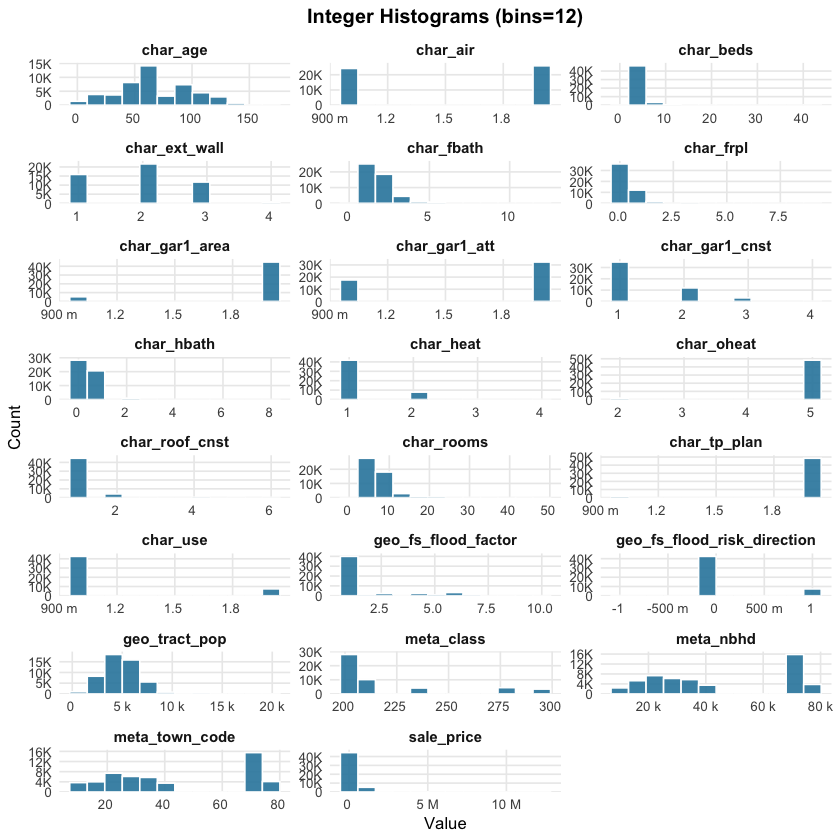

In [156]:
# =====================================================
# NUMERIC VARIABLES: HISTOGRAMS
# =====================================================

cat("
=== Integer Distributions (Faceted Histograms) ===
")

if(length(integer_vars) > 0) {
  bins_to_use <- max(9, min(12, ceiling(sqrt(nrow(historic_data)))))
  int_long <- historic_data %>%
    select(all_of(integer_vars)) %>%
    pivot_longer(everything(), names_to = "Variable", values_to = "Value") %>%
    filter(!is.na(Value))

  p_int <- ggplot(int_long, aes(x = Value)) +
    geom_histogram(bins = bins_to_use, fill = "#2E86AB", color = "white", alpha = 0.9) +
    facet_wrap(~Variable, scales = "free", ncol = 3) +
    scale_x_continuous(labels = scales::label_number(scale_cut = scales::cut_si(""))) +
    scale_y_continuous(labels = scales::label_number(scale_cut = scales::cut_short_scale()), expand = expansion(mult = c(0, 0.08))) +
    theme_minimal(base_size = 10) +
    theme(
      plot.title = element_text(face = "bold", size = 12, hjust = 0.5),
      strip.text = element_text(face = "bold", size = 9),
      panel.grid.minor = element_blank()
    ) +
    labs(
      title = sprintf("Integer Histograms (bins=%d)", bins_to_use),
      x = "Value",
      y = "Count"
    )

  print(p_int)
}


In [157]:
# =====================================================
# ORDINAL VARIABLES: BAR/HISTOGRAM STYLE
# =====================================================

cat("
=== Ordinal Variable Distributions (Faceted Bars) ===
")

if(length(ordinal_vars) > 0) {
  ord_long <- bind_rows(lapply(ordinal_vars, function(v) {
    if(!v %in% names(historic_data)) return(NULL)
    data.frame(
      Variable = v,
      Level = historic_data[[v]]
    )
  })) %>% filter(!is.na(Level))

  p_ord <- ggplot(ord_long, aes(x = Level)) +
    geom_bar(fill = "#118AB2", color = "#073B4C", width = 0.75, alpha = 0.9) +
    facet_wrap(~Variable, scales = "free_x", ncol = 3) +
    theme_minimal(base_size = 10) +
    theme(
      plot.title = element_text(size = 12, face = "bold", hjust = 0.5),
      strip.text = element_text(face = "bold", size = 9),
      axis.text.x = element_text(angle = 30, hjust = 1, size = 8)
    ) +
    labs(
      title = "Ordinal Distributions (counts)",
      x = "Level",
      y = "Count"
    )

  print(p_ord)
}



=== Ordinal Variable Distributions (Faceted Bars) ===


ERROR: [1m[33mError[39m:[22m
[33m![39m Can't combine `..1$Level` <ordered<51c21>> and `..2$Level` <ordered<c56cc>>.



=== Continuous Variable Spread (Boxplots) ===


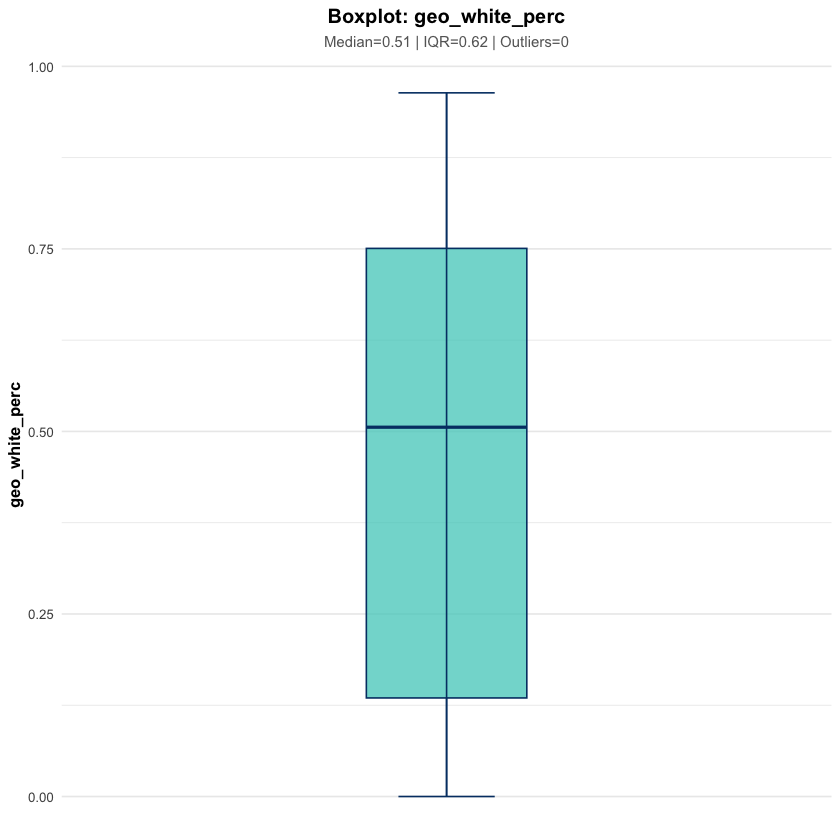

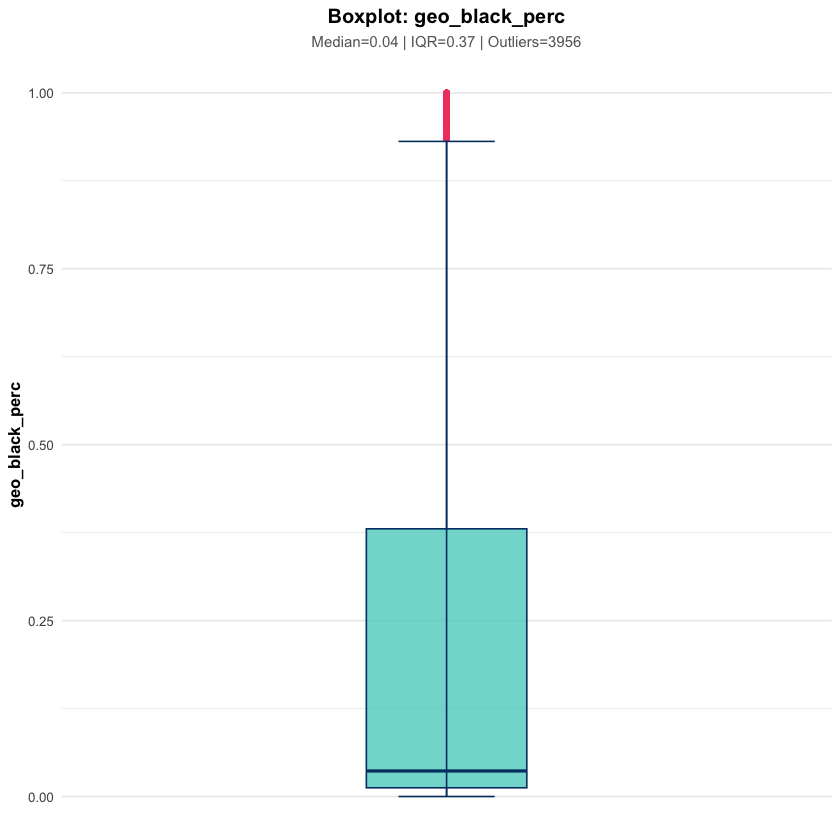

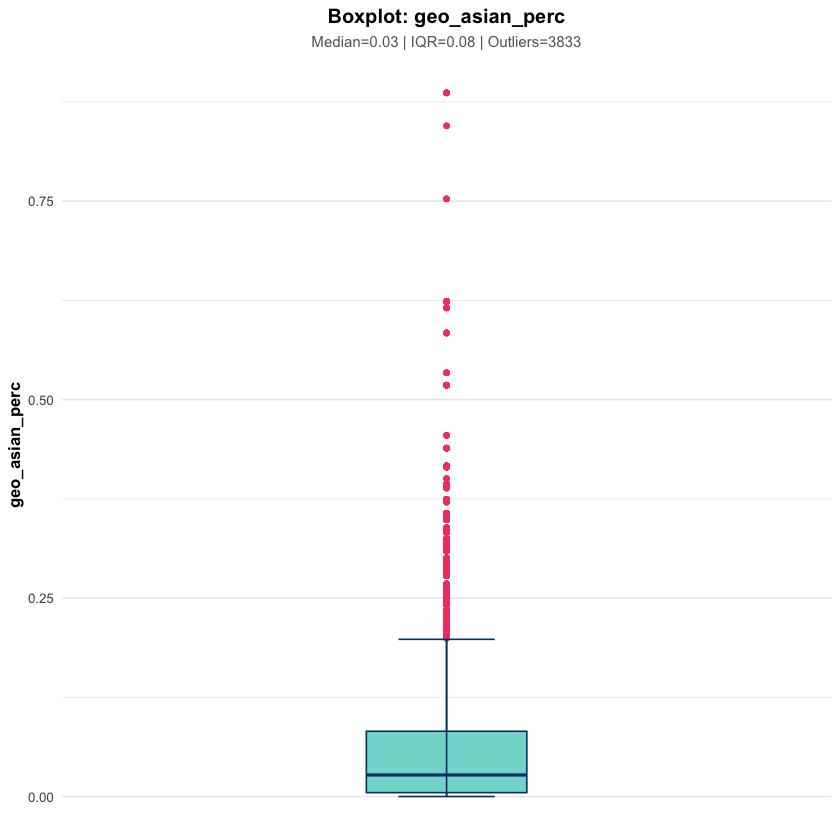

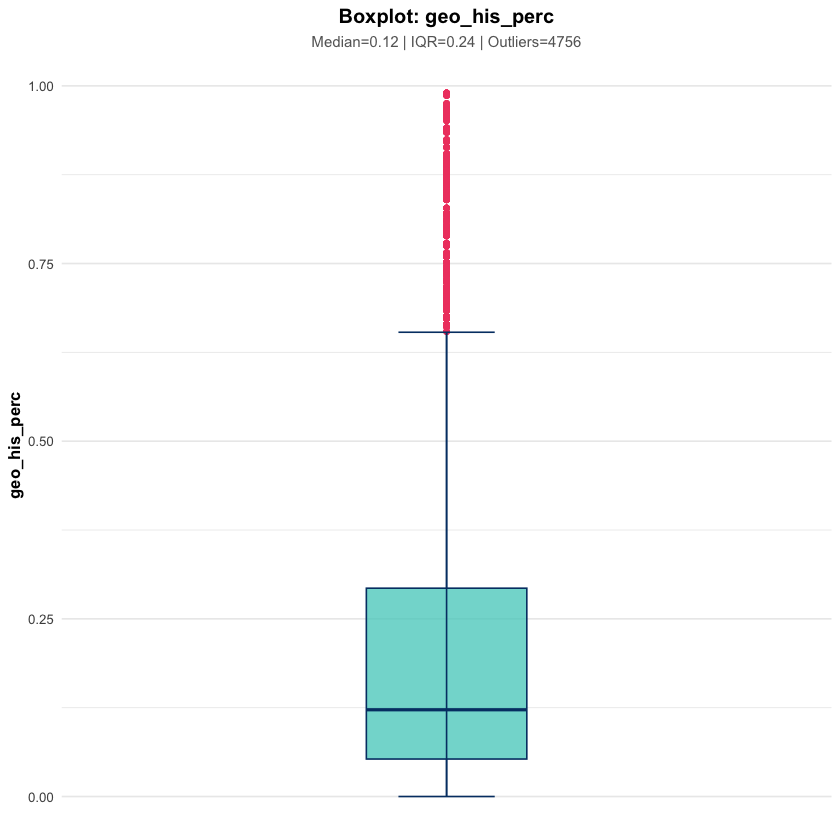

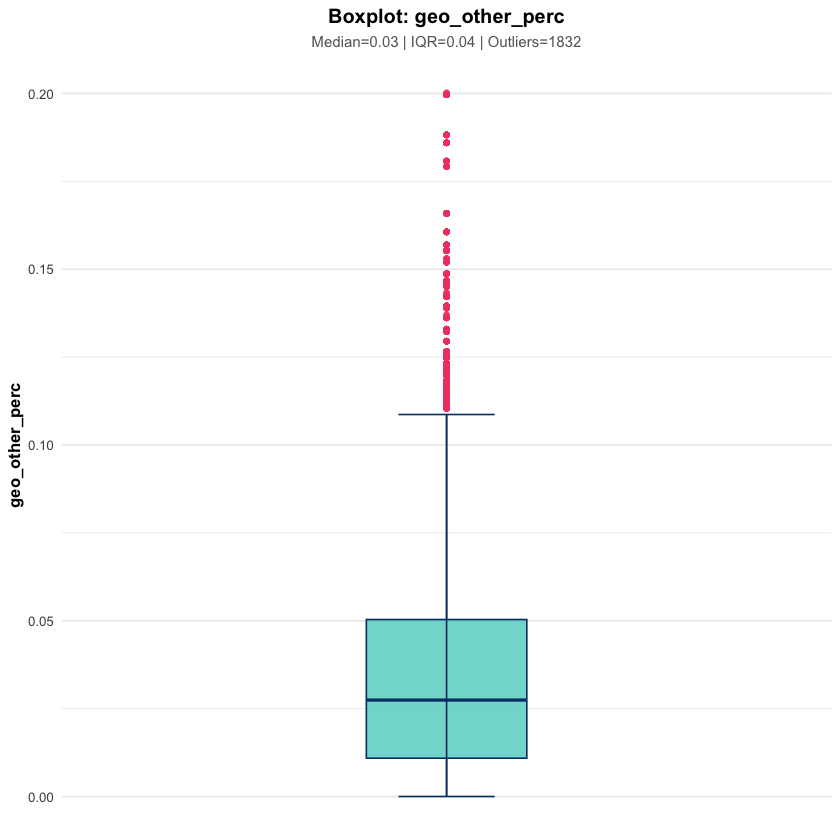

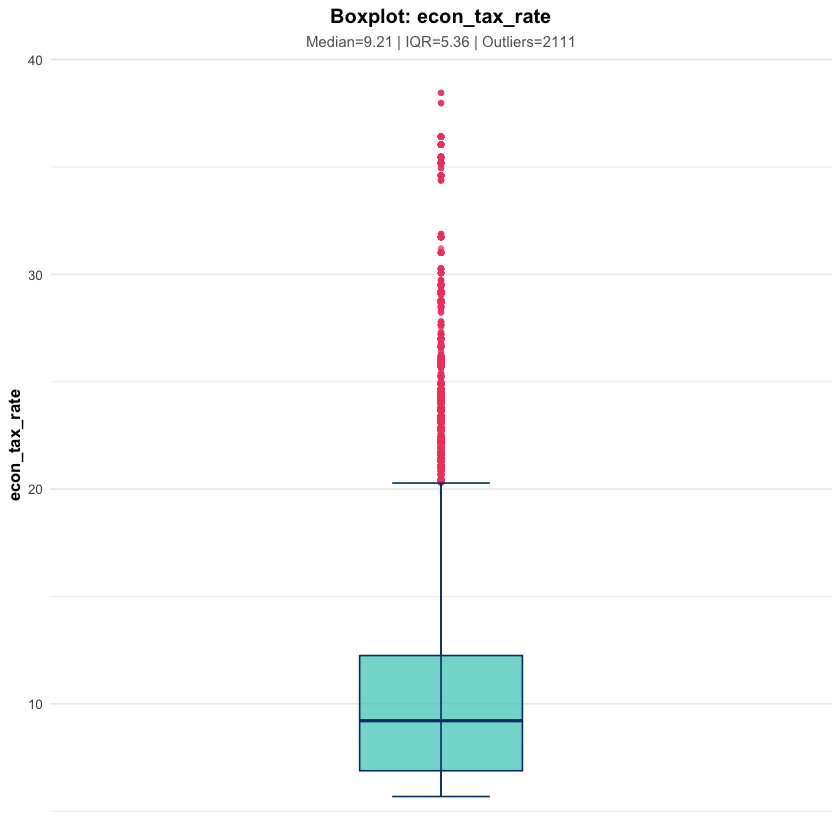

In [ ]:
# =====================================================
# CONTINUOUS VARIABLES: BOX & WHISKER PLOTS
# =====================================================

cat("
=== Continuous Variable Spread (Boxplots) ===
")

if(length(continuous_vars) > 0) {
  for(var in continuous_vars[1:min(8, length(continuous_vars))]) {
    Q1 <- quantile(historic_data[[var]], 0.25, na.rm = TRUE)
    Q3 <- quantile(historic_data[[var]], 0.75, na.rm = TRUE)
    IQR_val <- Q3 - Q1
    lower_bound <- Q1 - 1.5 * IQR_val
    upper_bound <- Q3 + 1.5 * IQR_val

    outlier_count <- historic_data %>%
      filter(!is.na(.data[[var]])) %>%
      filter(.data[[var]] < lower_bound | .data[[var]] > upper_bound) %>%
      nrow()

    p <- ggplot(historic_data, aes(y = .data[[var]], x = "")) +
      geom_boxplot(
        fill = "#4ECDC4",
        color = "#023E73",
        alpha = 0.75,
        outlier.colour = "#EF476F",
        outlier.shape = 16,
        outlier.size = 1.5,
        width = 0.25
      ) +
      stat_boxplot(aes(x = ""), geom = "errorbar", width = 0.15, color = "#023E73") +
      theme_minimal(base_size = 10) +
      theme(
        plot.title = element_text(size = 12, face = "bold", hjust = 0.5),
        plot.subtitle = element_text(size = 9, hjust = 0.5, color = "gray40"),
        axis.title = element_text(size = 10, face = "bold"),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        panel.grid.major.x = element_blank()
      ) +
      labs(
        title = paste("Boxplot:", var),
        subtitle = sprintf("Median=%.2f | IQR=%.2f | Outliers=%d", median(historic_data[[var]], na.rm = TRUE), IQR_val, outlier_count),
        y = var
      )

    print(p)
  }
}


In [ ]:
# =====================================================
# NOMINAL VARIABLES: PIE CHARTS
# =====================================================

cat("
=== Nominal Variable Distributions (Pie Charts) ===
")

if(length(nominal_vars) > 0) {
  for(var in nominal_vars[1:min(8, length(nominal_vars))]) {
    freq_table <- table(historic_data[[var]], useNA = "no")
    freq_df <- as.data.frame(freq_table) %>% arrange(desc(Freq))
    colnames(freq_df) <- c("Category", "Count")

    if(nrow(freq_df) > 7) {
      top_cats <- freq_df[1:7, ]
      other_count <- sum(freq_df$Count[8:nrow(freq_df)])
      freq_df <- rbind(top_cats, data.frame(Category = "Other", Count = other_count))
    }

    freq_df <- freq_df %>%
      mutate(
        Percentage = round(Count / sum(Count) * 100, 1),
        Label = ifelse(Percentage >= 2, paste0(Percentage, "%"), "")
      )

    p_pie <- ggplot(freq_df, aes(x = "", y = Count, fill = Category)) +
      geom_bar(stat = "identity", width = 1, color = "white", linewidth = 0.3) +
      coord_polar("y", start = 0) +
      geom_text(aes(label = Label), position = position_stack(vjust = 0.5), size = 3.0, fontface = "bold", color = "black") +
      theme_void() +
      theme(
        plot.title = element_text(size = 12, face = "bold", hjust = 0.5, margin = margin(b = 6)),
        plot.subtitle = element_text(size = 9, hjust = 0.5, color = "gray40", margin = margin(b = 10)),
        legend.position = "right",
        legend.title = element_text(size = 10, face = "bold"),
        legend.text = element_text(size = 8)
      ) +
      labs(
        title = paste("Pie Chart:", var),
        subtitle = sprintf("Levels=%d | Missing=%.1f%%", length(freq_table), mean(is.na(historic_data[[var]])) * 100),
        fill = "Category"
      ) +
      scale_fill_brewer(palette = "Set3")

    print(p_pie)
  }
}



=== Nominal Variable Distributions (Pie Charts) ===


ERROR: Error in margin.default(b = 6): argument "observed" is missing, with no default


In [ ]:
# =====================================================
# BOOLEAN VARIABLES: BAR CHARTS
# =====================================================

cat("
=== Boolean Variable Distributions (Bar Charts) ===
")

if(length(boolean_vars) > 0) {
  for(var in boolean_vars) {
    if(var %in% names(historic_data)) {
      vals <- as.logical(historic_data[[var]])
      freq_data <- data.frame(
        Value = c("TRUE", "FALSE"),
        Count = c(sum(vals, na.rm = TRUE), sum(!vals, na.rm = TRUE))
      ) %>%
        mutate(
          Percentage = round(Count / sum(Count) * 100, 1),
          Label = paste0(Percentage, "%")
        )

      p_bar <- ggplot(freq_data, aes(x = Value, y = Count, fill = Value)) +
        geom_bar(stat = "identity", color = "black", alpha = 0.85, width = 0.65) +
        geom_text(aes(label = Label), vjust = -0.4, size = 4, fontface = "bold") +
        theme_minimal(base_size = 11) +
        theme(
          plot.title = element_text(size = 13, face = "bold", hjust = 0.5),
          plot.subtitle = element_text(size = 9, hjust = 0.5, color = "gray40"),
          axis.title = element_text(size = 10, face = "bold"),
          axis.text = element_text(size = 10),
          legend.position = "none",
          panel.grid.major.x = element_blank()
        ) +
        labs(
          title = paste("Boolean Distribution:", var),
          subtitle = sprintf("Missing=%.1f%%", mean(is.na(vals)) * 100),
          x = "Value",
          y = "Count"
        ) +
        scale_fill_manual(values = c("TRUE" = "#4CAF50", "FALSE" = "#F44336")) +
        scale_y_continuous(expand = expansion(mult = c(0, 0.12)))

      print(p_bar)
    }
  }
}



=== Boolean Variable Distributions (Bar Charts) ===


ERROR: Error in Summary.factor(structure(c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, : ‘sum’ not meaningful for factors



=== Correlation Analysis ===

--- Pearson Correlations (numeric + boolean) ---


ERROR: Error in table(x, y): all arguments must have the same length


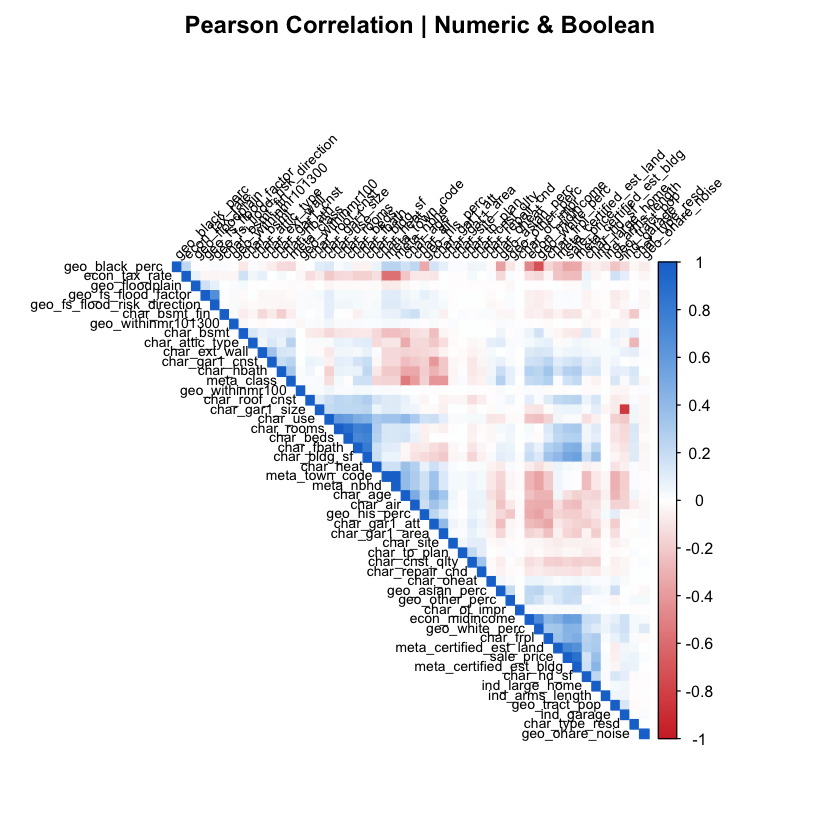

In [ ]:
# =====================================================
# CORRELATION ANALYSIS
# =====================================================

cat("
=== Correlation Analysis ===
")

numeric_for_corr <- unique(c(integer_vars, continuous_vars))
boolean_for_corr <- intersect(boolean_vars, names(historic_data))
ordinal_for_corr <- intersect(ordinal_vars, names(historic_data))
nominal_for_corr <- intersect(nominal_vars, names(historic_data))

# ---- Pearson for numeric + booleans ----
if(length(numeric_for_corr) + length(boolean_for_corr) >= 2) {
  cor_data <- historic_data %>% select(any_of(c(numeric_for_corr, boolean_for_corr)))
  # Encode booleans as 0/1 for correlation
  for(b in boolean_for_corr) {
    if(b %in% names(cor_data)) {
      cor_data[[b]] <- as.numeric(cor_data[[b]])
    }
  }

  cor_data <- cor_data %>% select(where(is.numeric)) %>% select(where(~var(.x, na.rm = TRUE) > 0))
  cor_matrix <- cor(cor_data, use = "pairwise.complete.obs", method = "pearson")

  cat("
--- Pearson Correlations (numeric + boolean) ---
")
  corrplot(cor_matrix,
           method = "color",
           type = "upper",
           order = "hclust",
           tl.col = "black",
           tl.srt = 45,
           tl.cex = 0.7,
           cl.cex = 0.8,
           col = colorRampPalette(c("#D32F2F", "#FFFFFF", "#1976D2"))(200),
           title = "Pearson Correlation | Integer/Continuous & Boolean",
           mar = c(0, 0, 2, 0))
}

# ---- Spearman for ordinal (rank-based) ----
if(length(ordinal_for_corr) >= 2) {
  ord_data <- historic_data %>% select(all_of(ordinal_for_corr))
  ord_data <- ord_data %>% mutate(across(everything(), ~as.numeric(as.factor(.x))))
  ord_matrix <- cor(ord_data, use = "pairwise.complete.obs", method = "spearman")

  cat("
--- Spearman Correlations (ordinal) ---
")
  corrplot(ord_matrix,
           method = "color",
           type = "upper",
           order = "hclust",
           tl.col = "black",
           tl.srt = 45,
           tl.cex = 0.7,
           cl.cex = 0.8,
           col = colorRampPalette(c("#F4B942", "#FFFFFF", "#3A86FF"))(200),
           title = "Spearman Correlation | Ordinal",
           mar = c(0, 0, 2, 0))
}

# ---- Cramer's V for nominal (categorical association) ----
cramers_v <- function(x, y) {
  tbl <- table(x, y)
  if(nrow(tbl) < 2 || ncol(tbl) < 2) return(NA_real_)
  chi <- suppressWarnings(chisq.test(tbl))
  n <- sum(tbl)
  min_dim <- min(nrow(tbl), ncol(tbl)) - 1
  if(min_dim == 0) return(NA_real_)
  sqrt(chi$statistic / (n * min_dim))[[1]]
}

nominal_for_corr_small <- nominal_for_corr[sapply(nominal_for_corr, function(v) {
  nlevels <- length(unique(historic_data[[v]]))
  nlevels > 1 && nlevels <= 15
})]
if(length(nominal_for_corr_small) > 10) {
  nominal_for_corr_small <- nominal_for_corr_small[1:10]
}

if(length(nominal_for_corr_small) >= 2) {
  k <- length(nominal_for_corr_small)
  cv_mat <- matrix(1, nrow = k, ncol = k, dimnames = list(nominal_for_corr_small, nominal_for_corr_small))
  for(i in seq_len(k)) {
    for(j in seq(i + 1, k)) {
      cv_val <- cramers_v(historic_data[[nominal_for_corr_small[i]]], historic_data[[nominal_for_corr_small[j]]])
      cv_mat[i, j] <- cv_val
      cv_mat[j, i] <- cv_val
    }
  }
  cv_df <- as.data.frame(as.table(cv_mat))
  colnames(cv_df) <- c("Var1", "Var2", "Value")
  cv_df <- cv_df[cv_df$Var1 != cv_df$Var2, ]

  cat("
--- Cramer's V (nominal associations) ---
")
  p_cv <- ggplot(cv_df, aes(x = Var1, y = Var2, fill = Value)) +
    geom_tile(color = "white") +
    scale_fill_gradient2(low = "#D32F2F", mid = "#FFFFFF", high = "#1976D2", midpoint = 0.3, limits = c(0, 1), oob = scales::squish) +
    theme_minimal(base_size = 11) +
    theme(
      axis.text.x = element_text(angle = 40, hjust = 1, size = 9),
      axis.text.y = element_text(size = 9),
      plot.title = element_text(face = "bold", hjust = 0.5)
    ) +
    labs(title = "Cramer's V | Nominal Associations", x = "", y = "", fill = "Cramer's V")

  print(p_cv)
}
